<img src="ml2_group_assignment.png" width="800"/>

# <font color=green> Introduction </font>

This is a continuation of forest_cover_type_detector_gr_a_Part1.

Above we import the files created in the previous notebook so that this notebook can run independently

Table of contents is an extension of the previous notebook

# <font color=green> Table of contents </font>

* [Libaries used](#0)
* [0. Import Data](#0)
* [__5. Feature Engineering__](#5) 
  * [5.1 Check for Anomalies and Outliers](#5.1)
       * [5.1.1 Outlier Detection Treatment using Inter-Quartile Range rule Function](#5.1.1)
       * [5.1.2 Inter-Quartile Range rule: 4 IQR from Median](#5.1.2)
       * [5.1.3 Inter-Quartile Range rule: 3 IQR from Median](#5.1.3)
  * [5.2 Feature Transformation and Building of new features](#5.2)
      * [5.2.1 Bivariate Combinations](#5.2.1)  
      * [5.2.2 Polynominal](#5.2.2)
      * [5.2.3 ID](#5.2.3)  
      * [5.2.4 Distance to Hydrology](#5.2.4)   
      * [5.2.5 Horizontal Distance To Roadways ](#5.2.5) 
      * [5.2.6 Slope](#5.2.6)  
      * [5.2.7 Horizontal Distance To Fire Points ](#5.2.7)  
      * [5.2.8 Hillshade](#5.2.8) 
          * [5.2.8.1 Mean Hillshade](#5.2.8.1) 
          * [5.2.8.2 Hillshade 9am](#5.2.8.2)
          * [5.2.8.3 Hillshade Noon](#5.2.8.3)          
          * [5.2.8.4 Hillshade 3pm](#5.2.8.4)       
          * [5.2.8.5 Hillshade Ratios](#5.2.8.5)        
      * [5.2.9 Geoclimate Groping](#5.2.9) 
* [__6. Feature Selection__](#6)
  * [6.0 Prepare Data and Standardization](#6.1)
  * [6.1 Single tree](#6.2) 
  * [6.2 Bagging](#6.2) 
  * [6.3 Random Forest](#6.3)  
  * [6.4 Extra Trees](#6.4)
       * [6.4.1 Feature Number Selecion](#6.6.1)       
       * [6.4.2 Lasso Regularization](#6.6.2)
       * [6.4.3 Filter Methods](#6.6.3)   
  * [6.5 Recursive Feature Elimination](#6.5)  
  * [6.6 Tree Based Methodologies](#6.6) 
       * [6.6.1 RandomForestClassifier](#6.6.1)       
       * [6.6.2 XGBoost](#6.6.2)
       * [6.6.3 Extra trees Classifier](#6.6.3)       
  * [6.7 Score of all methods Together](#6.7) 


<img src="roosevelt-national-forest.jpeg" width=1200 height=800 align="center">

<a id='0'></a>
# <font color=green> Libraries used </font>

In [1]:
#!pip install squarify
#!pip install htmltabletomd
#!pip install GraphViz
#!pip install pygraphviz

In [2]:
import pandas as pd
import numpy as np
import math 
import seaborn as sns  # Graphing
import matplotlib.pyplot as plt
import squarify #treemap
import matplotlib.pyplot as plt
import warnings
import plotly.graph_objects as go
import xgboost as xgb
import scipy.stats as stats
import htmltabletomd
import pydotplus

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn import datasets
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm


from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import rfecv


from plotly.subplots import make_subplots
from IPython.display import Image  
from io import StringIO


from itertools import combinations

from dtreeviz.trees import *


from numpy import percentile

warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='0'></a>
##  <font color=green>0.Import the Data </font>

Let’s load the original Kaggle training and test data and create a data frame

In [4]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

Let's keep the original dataset for later comparisons and make a copy for the FE process

In [5]:
df_original = data_train.copy()

<a id='5'></a>
<a id='5.1'></a>
# <font color=green>  5.Feature Engineering<font>
# <font color=green>  5.1. Check for Anomalies and Outliers <font>

Since the Z-score is sensitive to the  mean and standard deviation and its assumption is a normal distribution, we cannot use the z-score for outlier handling because our data is skewed and failed to pass the normal test. Our data is not normally distributed or at least not just yet.

The disadvantage using percentiles is that it considers always elements at both sides of the spectrum of the lowest or highest value, which can potentially be mistaken as outliers. 

As the number of observations increases, so does the number of observations considered outliers. After all, using a percentile based method will always flat-out and reject a certain percentage of our observations.Thus, we need to use the percentiles with caution. 

<a id='5.1.1'></a>
### <font color=darkcyan> 5.1.1 Outlier Detection Treatment using Inter-Quartile Range rule Function <font>

The IQR is the difference between the 75th and 25th percentile. The IQR is more resistant to outliers. The IQR by definition only covers the middle 50% of the data, so outliers are well outside this range and the presence of a small number of outliers is not likely to change this significantly. 

Now we are testing different ranges for IQR, namely 2,3 and 4 to check for more extreme outlier values. 

In [6]:
def outlier_function(df, col_name,value_IQR):
    ''' This function detects first and third quartile and interquartile range for a given column
    of a dataframe. Then calculates upper and lower limits to determine outliers conservatively and
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(value_IQR*IQR)
    lower_limit = first_quartile-(value_IQR*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

<a id='5.1.2'></a>
### <font color=darkcyan> 5.1.2 Inter-Quartile Range rule: 4 IQR from Median <font>

We loop through all columns to see if there are any outliers, for all values which are not only 0 and 1


In [7]:
for column in ["Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"]:
    if outlier_function(data_train, column,4)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(data_train, column,4)[2], column))

There are 13 outliers in Vertical_Distance_To_Hydrology
There are 1 outliers in Hillshade_9am


There is 1 record of Hillshade_9am with a zero value, which is a valid value as Hillshade can be zero. This is because there are parts in the mountain that never see the sunlight (blind spots). Hence we keep the value as it is. 

Now we remove outliers and test again in our baseline model


In [8]:
q25, q75 = percentile(data_train['Vertical_Distance_To_Hydrology'], 25), percentile(data_train['Vertical_Distance_To_Hydrology'], 75)
iqr = q75 - q25
# calculate the outlier cutoff
cut_off = iqr * 4
lower, upper = q25 - cut_off, q75 + cut_off
# remove outliers
data_train_vd_h = data_train[(data_train['Vertical_Distance_To_Hydrology'] > lower) & (data_train['Vertical_Distance_To_Hydrology'] < upper)]

Checking up to see if the model improves after removing vertical distance to hydrology 

In [9]:
X4=data_train_vd_h.drop(labels=['Id','Cover_Type'],axis=1)
y4=data_train_vd_h['Cover_Type']

In [10]:
scale_numerical =['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
            'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()
X4[scale_numerical]=scaler.fit_transform(X4[scale_numerical])

In [11]:
y4.value_counts()

5    2160
3    2160
6    2160
4    2160
1    2159
2    2157
7    2151
Name: Cover_Type, dtype: int64

In [12]:
X4_train,X4_val,y4_train,y4_val = train_test_split(X4,y4,random_state=37) #seed is 37!

In [13]:
forest_iqr4 = RandomForestClassifier(random_state=37)
model_forest_iqr4 = forest_iqr4.fit(X4_train,y4_train)

In [14]:
# calculating accuracy_score
model_forest_iqr4.score(X4_val,y4_val)

0.8607360338893302

In [15]:
forest = RandomForestClassifier(random_state=37)
print("Accuracy = {0:.4f}".format(np.mean(cross_val_score(model_forest_iqr4, X4_val, y4_val))))

Accuracy = 0.7993


<table>
  <tr>
    <th><b>Algorithm</b></th>
    <th><b>Accuracy</b></th>
    <th><b>CV Accuracy</b></th>
    <th><b>Accuracy with IQR4</b></th>
    <th><b>CV Accuracy with IQR4</b></th>
  </tr>
  <tr>
<td> Random Forest  </td>
    <td> <b>0.8613<b></td>
    <th><b>0.8016</b></th>
      <td> 0.8607</td>
      <td> 0.7993</td>
  </tr>     
  </tr>
</table>


Comparing the previous score with the new score after removing the outliers of vertical distance to Hydrology: Accuracy decresases slightly, hence better not to remove outliers.

#### <font color=darkcyan> Replacing with Median <font>
Since removing outliers improved performance of our model, using median values to keep a balanced sample set seems to be a reasonable approach. Otherwise the data becomes unbalanced, for which, other tools have to be used



<a id='5.1.3'></a>
### <font color=darkcyan> 5.1.3 Inter-Quartile Range rule: 3 IQR <font>

First we are checking which variables will be removed using the 3 IQR dunction Hillshade_9am,Hillshade_Noon,Hillshade_3pm has been excluded as these are valid outliers. 

In [16]:
for column in ["Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points"]:
    if outlier_function(data_train, column,3)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(data_train, column,3)[2], column))

There are 53 outliers in Horizontal_Distance_To_Hydrology
There are 49 outliers in Vertical_Distance_To_Hydrology
There are 3 outliers in Horizontal_Distance_To_Roadways
There are 132 outliers in Horizontal_Distance_To_Fire_Points


In [17]:
cols = ["Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"] # one or more

Q1 = data_train[cols].quantile(0.25)
Q3 = data_train[cols].quantile(0.75)
IQR = Q3 - Q1

df = data_train[~((data_train[cols] < (Q1 - 3 * IQR)) |(data_train[cols] > (Q3 + 3 * IQR))).any(axis=1)]

In [18]:
df.shape

(14866, 56)

In [19]:
X3=df.drop(labels=['Cover_Type'],axis=1)
y3=df['Cover_Type']

scale_numerical =['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
            'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()
X3[scale_numerical]=scaler.fit_transform(X3[scale_numerical])

Looking at the cover types you can see the values become unbalanced if we decided to remove them. 

In [20]:
y3.value_counts()

4    2160
6    2159
3    2153
5    2121
1    2113
7    2088
2    2072
Name: Cover_Type, dtype: int64

In [21]:
X_train3,X_val3,y_train3,y_val3 = train_test_split (X3,y3,random_state=37) #seed is 37!

In [22]:
forest_iqr3 = RandomForestClassifier(random_state=37)
model_forest_iqr3 = forest_iqr3.fit(X_train3,y_train3)

In [23]:
model_forest_iqr3.score(X_val3,y_val3)

0.87409200968523

In [24]:
forest_iqr3 = RandomForestClassifier(random_state=37)
print("Accuracy = {0:.4f}".format(np.mean(cross_val_score(model_forest_iqr3, X_val3, y_val3))))

Accuracy = 0.8025


<table>
  <tr>
    <th><b>Algorithm</b></th>
    <th><b>Accuracy Baseline</b></th>
    <th><b>CV Accuracy Baseline</b></th>
    <th><b>Accuracy with IQR3</b></th>
    <th><b>CV Accuracy with IQR3</b></th>
      </tr>
    </tr>
<td> Random Forest  </td>
    <td> <b>0.8613<b></td>
    <th><b>0.8016</b></th>
    <td> 0.8740</td>
    <td> 0.8025</td>
      </tr>     
    </tr>
</table>

Using the IQR3 rule to remove all outliers does not significantly improve the model hence we will not remove any outliers using IQR3. 

<a id='5.1.3'></a>
### <font color=darkcyan> 5.1.3 Inter-Quartile Range rule: 1.5 IQR <font>

First we are checking which variables will be removed using the 3 IQR dunction Hillshade_9am,Hillshade_Noon,Hillshade_3pm has been excluded as these are valid outliers. 

In [25]:
for column in ["Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points"]:
    if outlier_function(data_train, column,1.5)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(data_train, column,1.5)[2], column))

There are 512 outliers in Horizontal_Distance_To_Hydrology
There are 586 outliers in Vertical_Distance_To_Hydrology
There are 830 outliers in Horizontal_Distance_To_Roadways
There are 645 outliers in Horizontal_Distance_To_Fire_Points


In [26]:
cols = ["Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"] # one or more

Q1 = data_train[cols].quantile(0.25)
Q3 = data_train[cols].quantile(0.75)
IQR = Q3 - Q1

df1 = data_train[~((data_train[cols] < (Q1 - 1.5 * IQR)) |(data_train[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [27]:
df1.shape

(12261, 56)

In [28]:
X1=df1.drop(labels=['Cover_Type'],axis=1)
y1=df1['Cover_Type']

scale_numerical =['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
            'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()
X1[scale_numerical]=scaler.fit_transform(X1[scale_numerical])

Looking at the cover types you can see the values become unbalanced if we decided to remove them. 

In [29]:
y1.value_counts()

4    2055
6    1912
5    1814
3    1780
7    1606
1    1555
2    1539
Name: Cover_Type, dtype: int64

In [30]:
X_train1,X_val1,y_train1,y_val1 = train_test_split (X1,y1,random_state=37) #seed is 37!

In [31]:
forest_iqr1 = RandomForestClassifier(random_state=37)
model_forest_iqr1 = forest_iqr1.fit(X_train1,y_train1)

In [32]:
model_forest_iqr1.score(X_val1,y_val1)

0.8701891715590345

In [33]:
forest_iqr1 = RandomForestClassifier(random_state=37)
print("Accuracy = {0:.4f}".format(np.mean(cross_val_score(model_forest_iqr1, X_val1, y_val1))))

Accuracy = 0.8001


<table>
  <tr>
    <th><b>Algorithm</b></th>
    <th><b>Accuracy Baseline</b></th>
    <th><b>CV Accuracy Baseline</b></th>
    <th><b>Accuracy with IQR3</b></th>
    <th><b>CV Accuracy with IQR3</b></th>
      </tr>
    </tr>
<td> Random Forest  </td>
    <td> <b>0.8613<b></td>
    <th><b>0.8016</b></th>
    <td> 0.8701</td>
    <td> 0.8001</td>
      </tr>     
    </tr>
</table>

Using the IQR1.5 rule to remove all outliers does not significantly improve the model hence we will not remove any outliers. 

<a id='5.2'></a>
## <font color=green> 5.2 Feature Transformation and Building of new features <font>

<a id='5.2.1'></a>
### <font color=green> 5.2.1 Bivariate Combinations <font>

During feature engineering, we want to try to create a wide variety of interactions between multiple variables in order to create new variables. 


By manipulating them together, we create opportunities to have new and impactful features which could potentially impact our target variable, thus engineering our features. 

For this argument, we will create as many bivariate combinations of our predicting variables using the ‘combinations’ method from itertools library.

We will not make interactions with the dummy variables as these are either 0 or 1 and we will not get any additional information from making the interaction this way. 

Furthermore, it is not recommended to use standardization before bivariate combinations as we want to increase the signal. <br>

Sources: https://towardsdatascience.com/feature-engineering-combination-polynomial-features-3caa4c77a755 <br>

https://samchaaa.medium.com/preprocessing-why-you-should-generate-polynomial-features-first-before-standardizing-892b4326a91d

In order to use the bivariate combination we split the dataset for using it.Note this is not the split we will use later for testing the algorithm. This has only the purpose of testing all the combination and selecting the best once. 

In [34]:
# Identify and drop our target variable 'Cover_Type' from dataframe
X = data_train.drop('Cover_Type', axis = 1)

# Isolate our dependent variable as a feature
y = data_train['Cover_Type']

Train Test Split (80/20 size), drop duplicates and missing values


In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state=37, stratify=y)

X_train.drop_duplicates(inplace = True)
X_train.dropna(inplace = True)

C:\Users\Pedro\AppData\Local\Temp\ipykernel_338508\3614906890.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop_duplicates(inplace = True)
C:\Users\Pedro\AppData\Local\Temp\ipykernel_338508\3614906890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.dropna(inplace = True)


Here, we create every possible bivariate combination to be tested for feature engineering, no dummies


We take categorical variables prior to our feature engineering

In [36]:
column_list = X_train.columns
filtered_column_list = [column for column in column_list if 'Soil_Type' not in column and 'Wilderness_Area' not in column and 'Id' not in column ] 
interactions = list(combinations(filtered_column_list, 2))
interactions

[('Elevation', 'Aspect'),
 ('Elevation', 'Slope'),
 ('Elevation', 'Horizontal_Distance_To_Hydrology'),
 ('Elevation', 'Vertical_Distance_To_Hydrology'),
 ('Elevation', 'Horizontal_Distance_To_Roadways'),
 ('Elevation', 'Hillshade_9am'),
 ('Elevation', 'Hillshade_Noon'),
 ('Elevation', 'Hillshade_3pm'),
 ('Elevation', 'Horizontal_Distance_To_Fire_Points'),
 ('Aspect', 'Slope'),
 ('Aspect', 'Horizontal_Distance_To_Hydrology'),
 ('Aspect', 'Vertical_Distance_To_Hydrology'),
 ('Aspect', 'Horizontal_Distance_To_Roadways'),
 ('Aspect', 'Hillshade_9am'),
 ('Aspect', 'Hillshade_Noon'),
 ('Aspect', 'Hillshade_3pm'),
 ('Aspect', 'Horizontal_Distance_To_Fire_Points'),
 ('Slope', 'Horizontal_Distance_To_Hydrology'),
 ('Slope', 'Vertical_Distance_To_Hydrology'),
 ('Slope', 'Horizontal_Distance_To_Roadways'),
 ('Slope', 'Hillshade_9am'),
 ('Slope', 'Hillshade_Noon'),
 ('Slope', 'Hillshade_3pm'),
 ('Slope', 'Horizontal_Distance_To_Fire_Points'),
 ('Horizontal_Distance_To_Hydrology', 'Vertical_Distanc

Addition and division has been taken out as it created a lot of noise in the data. The division makes sense if it has a business meaning and the addition only if it is the same scale. 

However we will add the variables which have the same metrics together in a second step but not in a for loop. 

In [37]:
for (key, value) in interactions:
    data_train[key + '_x_' + value] = data_train[key] * data_train[value]
    #data_train[key + '_+_' + value] = data_train[key] + data_train[value]
    #data_train[key + '_divide_' + value] = data_train[key] / data_train[value]

In [38]:
pd.set_option('display.max_columns', None) #to make all columns visible in dataframe now that we have many
data_train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,132396,7788,669768,0,1323960,573716,602272,384208,16300284,153,13158,0,26010,11271,11832,7548,320229,774,0,1530,663,696,444,18837,0,131580,57018,59856,38184,1619982,0,0,0,0,0,112710,118320,75480,3202290,51272,32708,1387659,34336,1456728,929292
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,145040,5180,549080,-15540,1010100,569800,608650,391090,16122750,112,11872,-336,21840,12320,13160,8456,348600,424,-12,780,440,470,302,12450,-1272,82680,46640,49820,32012,1319700,-2340,-1320,-1410,-906,-37350,85800,91650,58890,2427750,51700,33220,1369500,35485,1462875,939975
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,389756,25236,751472,182260,8916720,656136,667352,378540,17163284,1251,37252,9035,442020,32526,33082,18765,850819,2412,585,28620,2106,2142,1215,55089,17420,852240,62712,63784,36180,1640428,206700,15210,15470,8775,397865,744120,756840,429300,19464780,55692,31590,1432314,32130,1456798,826335
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,431675,50130,673970,328630,8605650,662830,662

<a id='5.2.2'></a>
### <font color=green> 5.2.2 Polynomial Features <font>
    
We have just seen how to make two variables interact together, but sometimes the relationship between dependent and independent variables are more complex and not linear. 
    
Polynomials is another way to create new features! A very strong option for new features is increasing the power of a single variable. 
    
For our purposes, we will try and see if all the existing variables, can improve our Baseline by being increased to the  power.<br>
Source: https://towardsdatascience.com/feature-engineering-combination-polynomial-features-3caa4c77a755

Here we select only the columns we are interested in, this is from column 2 to 9

In [39]:
X_train_int_pf = data_train.iloc[:, 1:10]
X_train_int_pf

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm
0,2596,51,3,258,0,510,221,232,148
1,2590,56,2,212,-6,390,220,235,151
2,2804,139,9,268,65,3180,234,238,135
3,2785,155,18,242,118,3090,238,238,122
4,2595,45,2,153,-1,391,220,234,150
...,...,...,...,...,...,...,...,...,...
15115,2607,243,23,258,7,660,170,251,214
15116,2603,121,19,633,195,618,249,221,91
15117,2492,134,25,365,117,335,250,220,83
15118,2487,167,28,218,101,242,229,237,119


By default, when running polynomials we lose the name of our labels. This function gives us the ability to preserve it with the name + the transformation done

In [40]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df



Polynominal features of degree two gives us 46 new features. Since we have already enough information, we will not go for Polynominal three to avoid dimensionality issues later on

In [41]:
output_df_pw2 = PolynomialFeatures_labeled(X_train_int_pf,2)
pd.set_option('display.max_columns', None)
output_df_pw2.shape

(15120, 55)

There are some fields duplicated with respect to the original df. This is a side effect of the function as normal features are replicated to the power of one which is still the same value so we delete these

In [42]:
column_list = output_df_pw2.columns
cols = [column for column in column_list if '^1' not in column]
output_df_pw2=output_df_pw2[cols]
output_df_pw2

,Constant Term,Elevation^2,Aspect^2,Slope^2,Horizontal_Distance_To_Hydrology^2,Vertical_Distance_To_Hydrology^2,Horizontal_Distance_To_Roadways^2,Hillshade_9am^2,Hillshade_Noon^2,Hillshade_3pm^2
0,1.0,6739216.0,2601.0,9.0,66564.0,0.0,260100.0,48841.0,53824.0,21904.0
1,1.0,6708100.0,3136.0,4.0,44944.0,36.0,152100.0,48400.0,55225.0,22801.0
2,1.0,7862416.0,19321.0,81.0,71824.0,4225.0,10112400.0,54756.0,56644.0,18225.0
3,1.0,7756225.0,24025.0,324.0,58564.0,13924.0,9548100.0,56644.0,56644.0,14884.0
4,1.0,6734025.0,2025.0,4.0,23409.0,1.0,152881.0,48400.0,54756.0,22500.0
...,...,...,...,...,...,...,...,...,...,...
15115,1.0,6796449.0,59049.0,529.0,66564.0,49.0,435600.0,28900.0,63001.0,45796.0
15116,1.0,6775609.0,14641.0,361.0,400689.0,38025.0,381924.0,62001.0,48841.0,8281.0
15117,1.0,6210064.0,17956.0,625.0,133225.0,13689.0,112225.0,62500.0,48400.0,6889.0
15118,1.0,6185169.0,27889.0,784.0,47524.0,10201.0,58564.0,52441.0,56169.0,14161.0


In [43]:
X_train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
1439,1440,2828,72,45,228,163,234,223,113,0,1443,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
14821,14822,3516,320,14,323,22,1608,182,225,183,2053,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6922,6923,2702,178,11,85,10,1040,225,247,152,457,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12884,12885,2200,152,8,0,0,1475,230,240,142,811,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1589,1590,3296,356,3,270,31,5672,214,234,157,524,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,3493,2155,347,9,30,-3,942,204,226,161,847,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7127,7128,3405,47,18,150,10,3302,223,198,103,2314,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2291,2292,2076,297,32,90,39,391,114,210,227,566,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2281,2282,2875,202,15,150,-10,1826,212,252,172,1482,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In here, we concatenate our output to consolidate the ponlynomials with the feature combinations

This results in a huge dataset. Just for curiosity we ran polynomials to the power of three and see that just the resulting dataframe is already bigger than the consolidated one above

In [44]:
output_df_pw3 = PolynomialFeatures_labeled(X_train_int_pf,3)
output_df_pw3

,Constant Term,Elevation^1,Aspect^1,Slope^1,Horizontal_Distance_To_Hydrology^1,Vertical_Distance_To_Hydrology^1,Horizontal_Distance_To_Roadways^1,Hillshade_9am^1,Hillshade_Noon^1,Hillshade_3pm^1,Elevation^2,Elevation^1 x Aspect^1,Elevation^1 x Slope^1,Elevation^1 x Horizontal_Distance_To_Hydrology^1,Elevation^1 x Vertical_Distance_To_Hydrology^1,Elevation^1 x Horizontal_Distance_To_Roadways^1,Elevation^1 x Hillshade_9am^1,Elevation^1 x Hillshade_Noon^1,Elevation^1 x Hillshade_3pm^1,Aspect^2,Aspect^1 x Slope^1,Aspect^1 x Horizontal_Distance_To_Hydrology^1,Aspect^1 x Vertical_Distance_To_Hydrology^1,Aspect^1 x Horizontal_Distance_To_Roadways^1,Aspect^1 x Hillshade_9am^1,Aspect^1 x Hillshade_Noon^1,Aspect^1 x Hillshade_3pm^1,Slope^2,Slope^1 x Horizontal_Distance_To_Hydrology^1,Slope^1 x Vertical_Distance_To_Hydrology^1,Slope^1 x Horizontal_Distance_To_Roadways^1,Slope^1 x Hillshade_9am^1,Slope^1 x Hillshade_Noon^1,Slope^1 x Hillshade_3pm^1,Horizontal_Distance_To_Hydrology^2,Horizontal_Distance_To_Hydrology^1 x Vertical_Distance_To_Hydrology^1,Horizontal_Distance_To_Hydrology^1 x Horizontal_Distance_To_Roadways^1,Horizontal_Distance_To_Hydrology^1 x Hillshade_9am^1,Horizontal_Distance_To_Hydrology^1 x Hillshade_Noon^1,Horizontal_Distance_To_Hydrology^1 x Hillshade_3pm^1,Vertical_Distance_To_Hydrology^2,Vertical_Distance_To_Hydrology^1 x Horizontal_Distance_To_Roadways^1,Vertical_Distance_To_Hydrology^1 x Hillshade_9am^1,Vertical_Distance_To_Hydrology^1 x Hillshade_Noon^1,Vertical_Distance_To_Hydrology^1 x Hillshade_3pm^1,Horizontal_Distance_To_Roadways^2,Horizontal_Distance_To_Roadways^1 x Hillshade_9am^1,Horizontal_Distance_To_Roadways^1 x Hillshade_Noon^1,Horizontal_Distance_To_Roadways^1 x Hillshade_3pm^1,Hillshade_9am^2,Hillshade_9am^1 x Hillshade_Noon^1,Hillshade_9am^1 x Hillshade_3pm^1,Hillshade_Noon^2,Hillshade_Noon^1 x Hillshade_3pm^1,Hillshade_3pm^2,Elevation^3,Elevation^2 x Aspect^1,Elevation^2 x Slope^1,Elevation^2 x Horizontal_Distance_To_Hydrology^1,Elevation^2 x Vertical_Distance_To_Hydrology^1,Elevation^2 x Horizontal_Distance_To_Roadways^1,Elevation^2 x Hillshade_9am^1,Elevation^2 x Hillshade_Noon^1,Elevation^2 x Hillshade_3pm^1,Elevation^1 x Aspect^2,Elevation^1 x Aspect^1 x Slope^1,Elevation^1 x Aspect^1 x Horizontal_Distance_To_Hydrology^1,Elevation^1 x Aspect^1 x Vertical_Distance_To_Hydrology^1,Elevation^1 x Aspect^1 x Horizontal_Distance_To_Roadways^1,Elevation^1 x Aspect^1 x Hillshade_9am^1,Elevation^1 x Aspect^1 x Hillshade_Noon^1,Elevation^1 x Aspect^1 x Hillshade_3pm^1,Elevation^1 x Slope^2,Elevation^1 x Slope^1 x Horizontal_Distance_To_Hydrology^1,Elevation^1 x Slope^1 x Vertical_Distance_To_Hydrology^1,Elevation^1 x Slope^1 x Horizontal_Distance_To_Roadways^1,Elevation^1 x Slope^1 x Hillshade_9am^1,Elevation^1 x Slope^1 x Hillshade_Noon^1,Elevation^1 x Slope^1 x Hillshade_3pm^1,Elevation^1 x Horizontal_Distance_To_Hydrology^2,Elevation^1 x Horizontal_Distance_To_Hydrology^1 x Vertical_Distance_To_Hydrology^1,Elevation^1 x Horizontal_Distance_To_Hydrology^1 x Horizontal_Distance_To_Roadways^1,Elevation^1 x Horizontal_Distance_To_Hydrology^1 x Hillshade_9am^1,Elevation^1 x Horizontal_Distance_To_Hydrology^1 x Hillshade_Noon^1,Elevation^1 x Horizontal_Distance_To_Hydrology^1 x Hillshade_3pm^1,Elevation^1 x Vertical_Distance_To_Hydrology^2,Elevation^1 x Vertical_Distance_To_Hydrology^1 x Horizontal_Distance_To_Roadways^1,Elevation^1 x Vertical_Distance_To_Hydrology^1 x Hillshade_9am^1,Elevation^1 x Vertical_Distance_To_Hydrology^1 x Hillshade_Noon^1,Elevation^1 x Vertical_Distance_To_Hydrology^1 x Hillshade_3pm^1,Elevation^1 x Horizontal_Distance_To_Roadways^2,Elevation^1 x Horizontal_Distance_To_Roadways^1 x Hillshade_9am^1,Elevation^1 x Horizontal_Distance_To_Roadways^1 x Hillshade_Noon^1,Elevation^1 x Horizontal_Distance_To_Roadways^1 x Hillshade_3pm^1,Elevation^1 x Hillshade_9am^2,Elevation^1 x Hillshade_9am^1 x Hillshade_Noon^1,Elevation^1 x Hillshade_9am^1 x Hillshade_3pm^1,Elevation^1 x Hillshade_Noo

<a id='5.2.3'></a>
### <font color=green> 5.2.3 ID <font>

We agree for the test to not remove ID because the ID is the unique indentifier to evaluate


For the train we will remove it as it doesn't add any value to the model

In [45]:
data_train.drop('Id',axis = 1, inplace = True)

<a id='5.2.4'></a>
### <font color=green> 5.2.4 Distance To Hydrology <font>
#### <font color=green> New Features <font>

We combine Vertical distance to Hydrology and Horizontal distance to Hydrology since these two are highly correlated. This suggests to attempt a diagonal distance to hidrology using the Pythagoras theorem.

We will call this newly engineered feature, Distance_To_Hydrology
 
Source : https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9

In [46]:
data_train['Distance_To_Hydrology'] = data_train['Horizontal_Distance_To_Hydrology']**2 +data_train['Vertical_Distance_To_Hydrology']**2
data_train['Distance_To_Hydrology'] = data_train['Distance_To_Hydrology']**0.5
data_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Distance_To_Hydrology
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,132396,7788,669768,0,1323960,573716,602272,384208,16300284,153,13158,0,26010,11271,11832,7548,320229,774,0,1530,663,696,444,18837,0,131580,57018,59856,38184,1619982,0,0,0,0,0,112710,118320,75480,3202290,51272,32708,1387659,34336,1456728,929292,258.000000
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,145040,5180,549080,-15540,1010100,569800,608650,391090,16122750,112,11872,-336,21840,12320,13160,8456,348600,424,-12,780,440,470,302,12450,-1272,82680,46640,49820,32012,1319700,-2340,-1320,-1410,-906,-37350,85800,91650,58890,2427750,51700,33220,1369500,35485,1462875,939975,212.084889
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,389756,25236,751472,182260,8916720,656136,667352,378540,17163284,1251,37252,9035,442020,32526,33082,18765,850819,2412,585,28620,2106,2142,1215,55089,17420,852240,62712,63784,36180,1640428,206700,15210,15470,8775,397865,744120,756840,429300,19464780,55692,31590,1432314,32130,1456798,826335,275.769832
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,4

#### <font color=green> Square root and logarithm Transformation  <font>

Now we are checking the distribution of the newly created variable and see if further transformation is needed. 

The Distance to Hydrology inherits skewness from parent variables. It is positively skewed and has zero values. 

In order to use log we will use log + 1 in order to use logarithm with zero values. 

Source: https://www.youtube.com/watch?v=_c3dVTRIK9c and 

Source_2: https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9

As a rule of thumb, the skewness can be interpreted as follows:
<img src="Skew.png" width=400 height=200 align="center">

Source: https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/

In [47]:
print('\033[95m'+"Skew before transformation\n", data_train['Distance_To_Hydrology'].skew(), 
      "\nmin\n", data_train['Distance_To_Hydrology'].min(),
      "\nmax\n", data_train['Distance_To_Hydrology'].max(),)

Skew before transformation
 1.4420723247653018 
min
 0.0 
max
 1356.9395712411072


We do some transformations to minimize skewness

In [48]:
#Using the log10+ 1 logarithm 
data_train['log10_Distance_To_Hydrology'] = np.log10(data_train['Distance_To_Hydrology']+1)

In [49]:
#Using the square root 
data_train['sqr_Distance_To_Hydrology'] = data_train['Distance_To_Hydrology']**0.5

#### <font color=green> Results after logarithm and <font color=darkcyan> Square root Transformation<font>

In [50]:
print('\033[92m' +"Skew after Log transformation\n", data_train['log10_Distance_To_Hydrology'].skew(), 
      "\nmin\n", data_train['log10_Distance_To_Hydrology'].min(),
      "\nmax\n", data_train['log10_Distance_To_Hydrology'].max(),)

Skew after Log transformation
 -1.6236384008076947 
min
 0.0 
max
 3.1328804441267675


In [51]:
print('\033[96m'+ "Skew after Square Root Transformation\n", data_train['sqr_Distance_To_Hydrology'].skew(), 
      "\nmin\n", data_train['sqr_Distance_To_Hydrology'].min(),
      "\nmax\n", data_train['sqr_Distance_To_Hydrology'].max(),)

Skew after Square Root Transformation
 0.0351310310927601 
min
 0.0 
max
 36.836660696120475


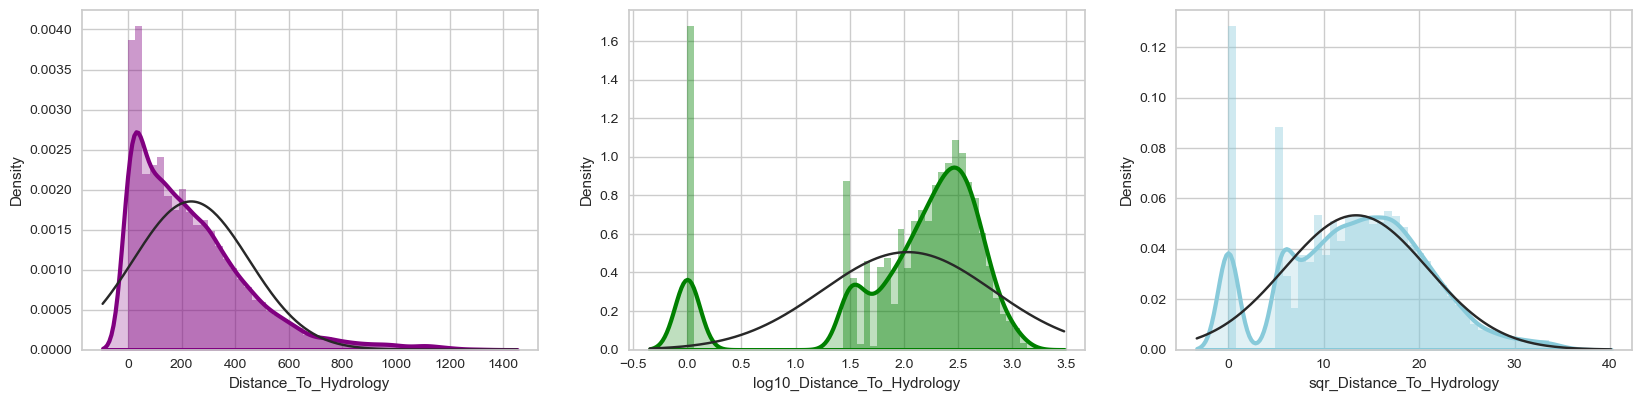

In [52]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,15))
f.add_subplot(331)
histPlot(data_train['Distance_To_Hydrology'], 'purple')
f.add_subplot(332)
histPlot(data_train['log10_Distance_To_Hydrology'], 'green')
f.add_subplot(333)
histPlot(data_train['sqr_Distance_To_Hydrology'], 'c')

As you can see above, for distance to Hydrology the __square root__ showed a better performance in terms of skewness and is closer to a normal bell shaped than the logarithm transformation. We will be using Square Root as a new feature in the dataset and will frop the others from the dataset.  

For now we only remove log10 but later we will delete also originals

In [53]:
data_train.drop(['log10_Distance_To_Hydrology'], axis=1,inplace=True)

<a id='5.2.5'></a>
### <font color=green> 5.2.5 Horizontal Distance To Roadways <font>

#### <font color=green> Square root and logarithm Transformation  <font>

For log transformation there should be no zeros, negative values and the distribution should be positive skewed( bigger than 1 is positive) hence we are using the square root as you can see for logarithm transformation below the distribution did not improve!!!

In [54]:
print('\033[95m'+"Skew before Transformation\n", data_train['Horizontal_Distance_To_Roadways'].skew(), 
      "\nmin before Transformation\n", data_train['Horizontal_Distance_To_Roadways'].min(),
      "\nmax before Transformation\n", data_train['Horizontal_Distance_To_Roadways'].max(),)

Skew before Transformation
 1.247810678465482 
min before Transformation
 0 
max before Transformation
 6890


#### <font color=green> Results after logarithm and <font color=darkcyan> Square root Transformation<font>

In [55]:
# since we have null values we add plus 1 to avoid log of zero.We are using natural log and log10
data_train['Sqr_Horizontal_Distance_To_Roadways'] = data_train['Horizontal_Distance_To_Roadways']**0.5
data_train['log_Horizontal_Distance_To_Roadways'] = np.log(data_train['Horizontal_Distance_To_Roadways']+1)
data_train['log10_Horizontal_Distance_To_Roadways'] = np.log10(data_train['Horizontal_Distance_To_Roadways']+1)

In [56]:
print('\033[96m'+ "Skew after Square Root Transformation\n", data_train['Sqr_Horizontal_Distance_To_Roadways'].skew(), 
      "\nmin \n", data_train['Sqr_Horizontal_Distance_To_Roadways'].min(),
      "\nmax \n", data_train['Sqr_Horizontal_Distance_To_Roadways'].max(),)


Skew after Square Root Transformation
 0.47623044767204115 
min 
 0.0 
max 
 83.00602387778854


In [57]:
print('\033[92m' +"Skew after log Transformation\n", data_train['log_Horizontal_Distance_To_Roadways'].skew(), 
      "\nmin\n", data_train['log_Horizontal_Distance_To_Roadways'].min(),
      "\nmax\n", data_train['log_Horizontal_Distance_To_Roadways'].max(),)

Skew after log Transformation
 -0.6892190307043193 
min
 0.0 
max
 8.837971491357209


In [58]:
print('\033[92m'+ "Skew after log10 transformation\n", data_train['log10_Horizontal_Distance_To_Roadways'].skew(), 
      "\nmin \n", data_train['log10_Horizontal_Distance_To_Roadways'].min(),
      "\nmax \n", data_train['log10_Horizontal_Distance_To_Roadways'].max(),)

Skew after log10 transformation
 -0.6892190307043152 
min 
 0.0 
max 
 3.8382822499146885


In [59]:
# testing if the sqaure root is normally distributed and it shows it is not, however it is less skewed than before
stats.normaltest(data_train['Sqr_Horizontal_Distance_To_Roadways'])

NormaltestResult(statistic=593.4024989110219, pvalue=1.3940700201238209e-129)

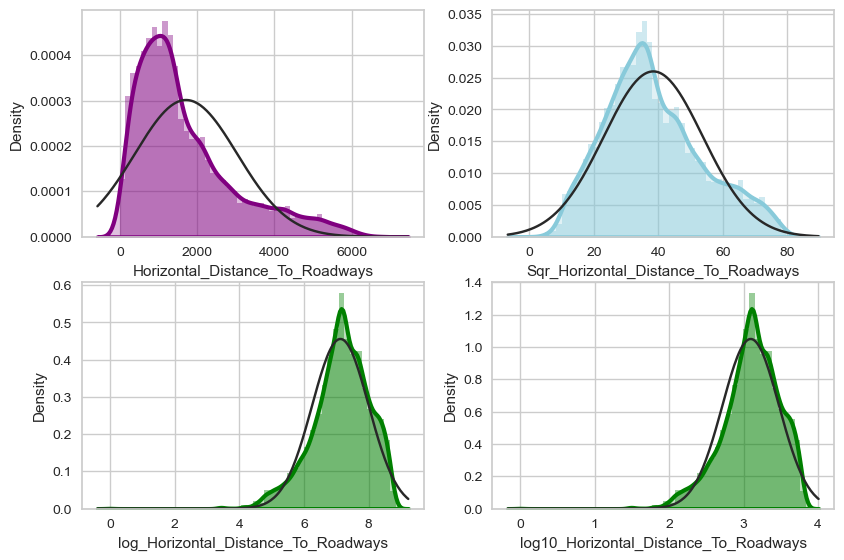

In [60]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(15,10))
f.add_subplot(331)
histPlot(data_train['Horizontal_Distance_To_Roadways'], 'purple')
f.add_subplot(334)
histPlot(data_train['log_Horizontal_Distance_To_Roadways'], 'green')
f.add_subplot(335)
histPlot(data_train['log10_Horizontal_Distance_To_Roadways'], 'green')
f.add_subplot(332)
histPlot(data_train['Sqr_Horizontal_Distance_To_Roadways'], 'c')

We achieved the best result again using square root of the Horizontal Distance to Roadways. Similarly as before, we remove failed experiments

In [61]:
data_train.drop(['log_Horizontal_Distance_To_Roadways','log10_Horizontal_Distance_To_Roadways'], axis=1,inplace=True)

<a id='5.2.6'></a>
### <font color=green> 5.2.6 Slope <font>
#### <font color=green> Square root and logarithm Transformation  <font>

In [62]:
print('\033[95m'+ "Skew before transformation\n", data_train['Slope'].skew(), 
      "\nmin\n", data_train['Slope'].min(),
      "\nmax \n", data_train['Slope'].max(),)

Skew before transformation
 0.5236583382936286 
min
 0 
max 
 52


#### <font color=green> Results after logarithm and <font color=darkcyan> Sqrare root Transformation<font>

In [63]:
# since we have null values we add plus 1 to avoid log of zero
data_train['logSlope'] = np.log(data_train['Slope']+1)

In [64]:
print('\033[92m'+"Skew after log transformation\n", data_train['logSlope'].skew(), 
      "\nmin\n", data_train['logSlope'].min(),
      "\nmax\n", data_train['logSlope'].max(),)

Skew after log transformation
 -0.7530340055684758 
min
 0.0 
max
 3.970291913552122


In [65]:
data_train['SqrSlope'] = data_train['Slope']**0.5

In [66]:
print('\033[96m'+"Skew after Square Root transformation\n", data_train['SqrSlope'].skew(), 
      "\nmin\n", data_train['SqrSlope'].min(),
      "\nmax\n", data_train['SqrSlope'].max(),)

Skew after Square Root transformation
 -0.09875824995364099 
min
 0.0 
max
 7.211102550927978


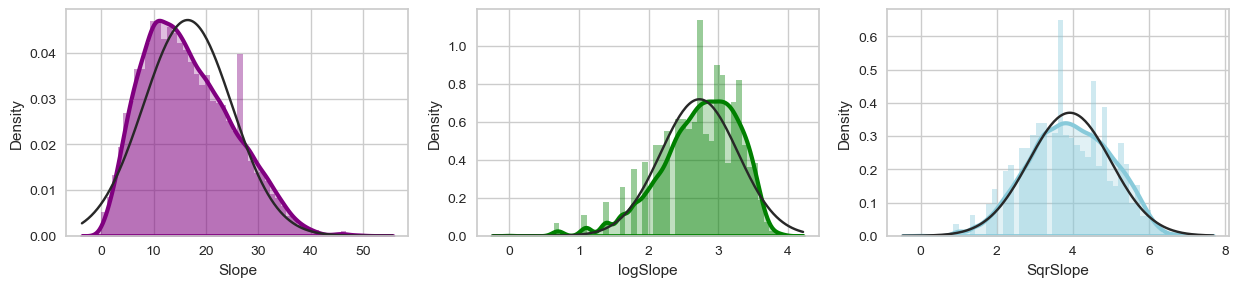

In [67]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(15,10))
f.add_subplot(331)
histPlot(data_train['Slope'], 'purple')
f.add_subplot(332)
histPlot(data_train['logSlope'], 'green')
f.add_subplot(333)
histPlot(data_train['SqrSlope'], 'c')

Since the skweness for the slope shows better performance when using the square root, we will transform the variable into square root as well. 

In [68]:
data_train.drop(['logSlope'], axis=1,inplace=True)

<a id='5.2.7'></a>
### <font color=green> 5.2.7 Horizontal Distance To Fire Points  <font>
#### <font color=green> Transformation  <font>

In [69]:
print('\033[95m'+"Skew before transformation\n", data_train['Horizontal_Distance_To_Fire_Points'].skew(), 
      "\nmin\n", data_train['Horizontal_Distance_To_Fire_Points'].min(),
      "\nmax\n", data_train['Horizontal_Distance_To_Fire_Points'].max(),)

Skew before transformation
 1.6170988738848289 
min
 0 
max
 6993


#### <font color=green> Results after logarithm and <font color=darkcyan> Sqrare root Transformation<font>

In [70]:
# since we have null values we add plus 1 to avoid log of zero
data_train['log_Horizontal_Distance_To_firepoints'] = np.log(data_train['Horizontal_Distance_To_Fire_Points']+1)

In [71]:
print('\033[92m'+"Skew after log transformation\n", data_train['log_Horizontal_Distance_To_firepoints'].skew(), 
      "\nmin\n", data_train['log_Horizontal_Distance_To_firepoints'].min(),
      "\nmax\n", data_train['log_Horizontal_Distance_To_firepoints'].max(),)

Skew after log transformation
 -0.6708653924261154 
min
 0.0 
max
 8.852807917623322


In [72]:
#Transform with square root
data_train['sqr_Horizontal_Distance_To_firepoints'] = data_train['Horizontal_Distance_To_Fire_Points']**0.5

In [73]:
print('\033[96m'+"Skew after Square Root transformation\n", data_train['sqr_Horizontal_Distance_To_firepoints'].skew(), 
      "\nmin\n", data_train['sqr_Horizontal_Distance_To_firepoints'].min(),
      "\nmax\n", data_train['sqr_Horizontal_Distance_To_firepoints'].max(),)

Skew after Square Root transformation
 0.5839887898581114 
min
 0.0 
max
 83.62415918859813


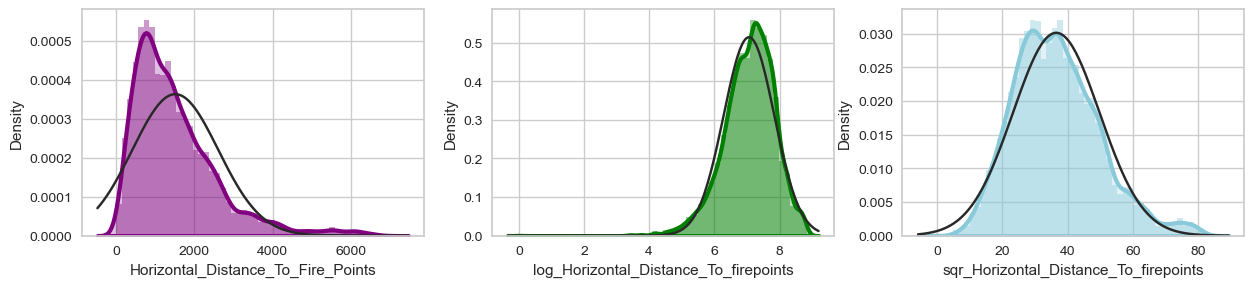

In [74]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(15,10))
f.add_subplot(331)
histPlot(data_train['Horizontal_Distance_To_Fire_Points'], 'purple')
f.add_subplot(332)
histPlot(data_train['log_Horizontal_Distance_To_firepoints'], 'green')
f.add_subplot(333)
histPlot(data_train['sqr_Horizontal_Distance_To_firepoints'], 'c')

Since square root transformation gives the best result in skewness, we will also use sqr for the feature variable.

In [75]:
data_train.drop(['log_Horizontal_Distance_To_firepoints'], axis=1,inplace=True)

<a id='5.2.8'></a>
### <font color=green> 5.2.8 Hillshades <font>
<a id='5.2.8.1'></a>
### <font color=green> 5.2.8.1 Mean Hillshade <font>
#### <font color=green> Creation of new Feature: Mean Hillshade <font>

In [76]:
# We take the average of Hillshades,which gives you the average light exposure of each cover type during the day
data_train['Mean_Hillshade'] = (data_train['Hillshade_9am']+data_train['Hillshade_Noon']+data_train['Hillshade_3pm'])/3

In [77]:
#Itensity of the Hillshade variables in 3 bin siizes with the bin discretizer
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
data_train['Mean_Hillshade_bin'] = est.fit_transform(data_train[['Mean_Hillshade']])

In [78]:
data_train[['Mean_Hillshade_bin','Mean_Hillshade']].describe()

,Mean_Hillshade_bin,Mean_Hillshade
count,15120.000000,15120.000000
mean,1.768122,188.920635
std,0.460708,17.125035
min,0.000000,105.666667
25%,2.000000,180.333333
50%,2.000000,192.333333
75%,2.000000,201.333333
max,2.000000,213.666667


In [79]:
print('\033[95m'+"Skew before transformation\n", data_train['Mean_Hillshade'].skew(), 
      "\nmin\n", data_train['Mean_Hillshade'].min(),
      "\nmax\n", data_train['Mean_Hillshade'].max(),)

Skew before transformation
 -1.0903510485555057 
min
 105.66666666666667 
max
 213.66666666666666


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>, Square root Transformation<font color=gold> and BoxCox Transformation<font>

In [80]:
data_train['log_Mean_Hillshade'] = np.log(data_train['Mean_Hillshade'])

In [81]:
print('\033[92m'+"Skew after log transformation\n", data_train['log_Mean_Hillshade'].skew(), 
      "\nmin\n", data_train['log_Mean_Hillshade'].min(),
      "\nmax\n", data_train['log_Mean_Hillshade'].max(),)

Skew after log transformation
 -1.4322026123219795 
min
 4.660289485209171 
max
 5.36441716825256


In [82]:
data_train['log10Mean_Hillshade'] = np.log10(data_train['Mean_Hillshade'])

In [83]:
print('\033[92m'+"Skew after log10 transformation\n", data_train['log10Mean_Hillshade'].skew(), 
      "\nmin\n", data_train['log10Mean_Hillshade'].min(),
      "\nmax\n", data_train['log10Mean_Hillshade'].max(),)

Skew after log10 transformation
 -1.4322026123219602 
min
 2.023938007498089 
max
 2.329736774799155


In [84]:
data_train['sqr_Mean_Hillshade'] = data_train['Mean_Hillshade']**0.5

In [85]:
print('\033[96m'+"Skew after Square Root transformation\n", data_train['sqr_Mean_Hillshade'].skew(), 
      "\nmin\n", data_train['sqr_Mean_Hillshade'].min(),
      "\nmax\n", data_train['sqr_Mean_Hillshade'].max(),)

Skew after Square Root transformation
 -1.25173398314383 
min
 10.279429296739517 
max
 14.617341299520465


In [86]:
#Now, the Box-Cox transformation also requires our data to only contain positive numbers
# transform training data with Boxcox
data_train['Mean_Hillshade_boxcox'], _ = stats.boxcox(data_train['Mean_Hillshade'])

In [87]:
print('\033[93m'+"Skew after Boxcox transformation\n", data_train['Mean_Hillshade_boxcox'].skew(), 
      "\nmin\n", data_train['Mean_Hillshade_boxcox'].min(),
      "\nmax\n", data_train['Mean_Hillshade_boxcox'].max(),)

Skew after Boxcox transformation
 -0.14515719864079082 
min
 9274946583.191551 
max
 382374055990.05743


In [88]:
stats.normaltest(data_train['Mean_Hillshade_boxcox'])

NormaltestResult(statistic=961.0422164343731, pvalue=2.0527415036077563e-209)

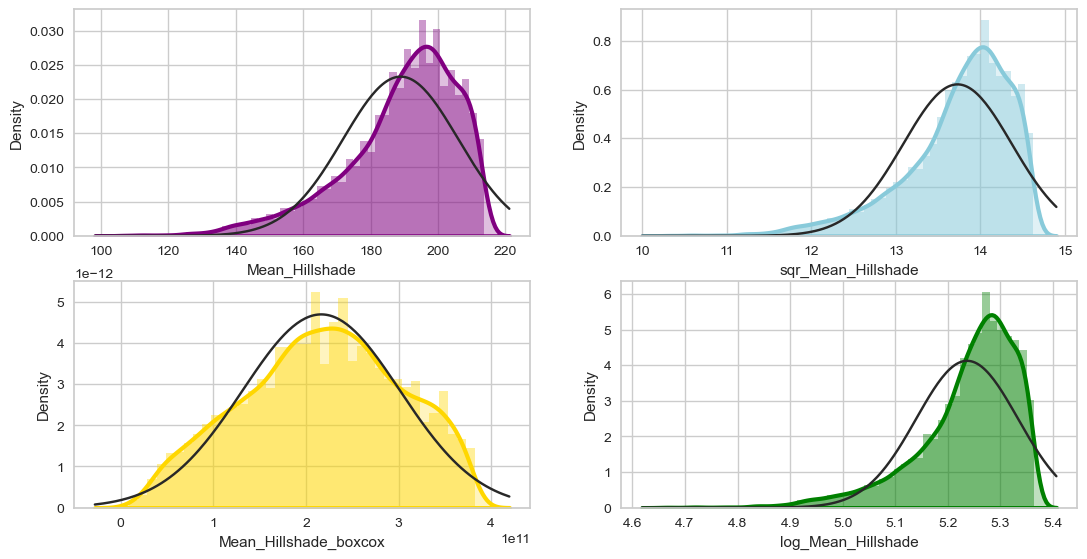

In [89]:
from scipy.stats import norm
import scipy.stats as stats

def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_train['Mean_Hillshade'], 'purple')
f.add_subplot(335)
histPlot(data_train['log_Mean_Hillshade'], 'green')
f.add_subplot(334)
histPlot(data_train['Mean_Hillshade_boxcox'], 'gold')                    
f.add_subplot(332)
histPlot(data_train['sqr_Mean_Hillshade'], 'c')

The distribution did not improve with Square Root and Logarithms Transformation. Hence we use BoxCox which improved the distribution substantially. 

In [90]:
data_train.drop(['log10Mean_Hillshade','log_Mean_Hillshade','sqr_Mean_Hillshade'], axis=1,inplace=True)

<a id='5.2.8.2'></a>
### <font color=green> 5.2.8.2 Hillshade 9am <font>
#### <font color=green> Transformation  <font>

In [91]:
print('\033[95m'+"Skew before transformation\n", data_train['Hillshade_9am'].skew(), 
      "\nmin\n", data_train['Hillshade_9am'].min(),
      "\nmax\n", data_train['Hillshade_9am'].max(),)

Skew before transformation
 -1.0936805605383073 
min
 0 
max
 254


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>, Square root Transformation<font color=gold> and BoxCox Transformation<font>

In [92]:
data_train['log_Hillshade_9am'] = np.log(data_train['Hillshade_9am']+1)

In [93]:
print('\033[92m'+"Skew after log transformation\n", data_train['log_Hillshade_9am'].skew(), 
      "\nmin\n", data_train['log_Hillshade_9am'].min(),
      "\nmax\n", data_train['log_Hillshade_9am'].max(),)

Skew after log transformation
 -3.708953816677303 
min
 0.0 
max
 5.541263545158426


In [94]:
data_train['sqr_Hillshade_9am'] = data_train['Hillshade_9am']**0.5

In [95]:
print('\033[96m'+"Skew after Square Root transformation\n", data_train['sqr_Hillshade_9am'].skew(), 
      "\nmin\n", data_train['sqr_Hillshade_9am'].min(),
      "\nmax\n", data_train['sqr_Hillshade_9am'].max(),)

Skew after Square Root transformation
 -1.4741589700243982 
min
 0.0 
max
 15.937377450509228


In [96]:
#Now, the Box-Cox transformation also requires our data to only contain positive numbers, transform training data with Boxcox
data_train['Hillshade_9am_boxcox'], lam  = stats.boxcox(data_train['Hillshade_9am']+1)
#lam is the best lambda for the distribution

In [97]:
print('\033[93m'+"Skew after Boxcox transformation\n", data_train['Hillshade_9am_boxcox'].skew(), 
      "\nmin\n", data_train['Hillshade_9am_boxcox'].min(),
      "\nmax\n", data_train['Hillshade_9am_boxcox'].max(),)

Skew after Boxcox transformation
 -0.1964508631897843 
min
 0.0 
max
 147303558.7348688


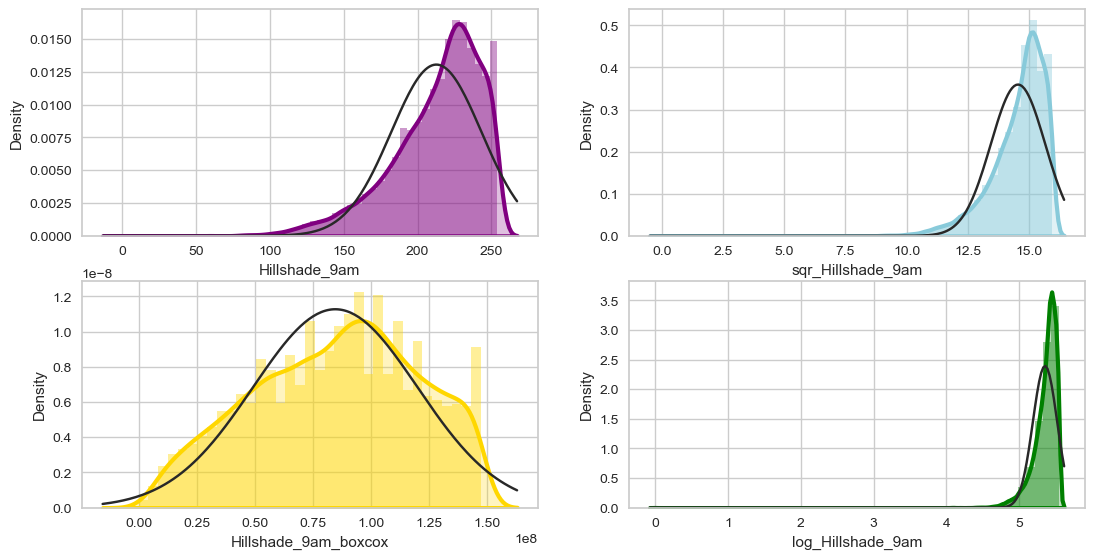

In [98]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_train['Hillshade_9am'], 'purple')
f.add_subplot(335)
histPlot(data_train['log_Hillshade_9am'], 'green')
f.add_subplot(334)
histPlot(data_train['Hillshade_9am_boxcox'], 'gold')                    
f.add_subplot(332)
histPlot(data_train['sqr_Hillshade_9am'], 'c')

BoxCox outperforms the other two for the Hillshade 9am 

In [99]:
data_train.drop(['log_Hillshade_9am','sqr_Hillshade_9am'], axis=1,inplace=True)

<a id='5.2.8.3'></a>
### <font color=green> 5.2.8.3 Hillshade Noon <font>
#### <font color=green> Transformation  <font>

In [100]:
print('\033[95m'+"Skew before transformation\n", data_train['Hillshade_Noon'].skew(), 
      "\nmin\n", data_train['Hillshade_Noon'].min(),
      "\nmax\n", data_train['Hillshade_Noon'].max(),)

Skew before transformation
 -0.9532317074981783 
min
 99 
max
 254


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>, Square root Transformation<font color=gold> and BoxCox Transformation<font>

In [101]:
data_train['log_Hillshade_Noon'] = np.log(data_train['Hillshade_Noon']+1)

In [102]:
print('\033[92m'+"Skew after log transformation\n", data_train['log_Hillshade_Noon'].skew(), 
      "\nmin\n", data_train['log_Hillshade_Noon'].min(),
      "\nmax\n", data_train['log_Hillshade_Noon'].max(),)

Skew after log transformation
 -1.4151877543194478 
min
 4.605170185988092 
max
 5.541263545158426


In [103]:
data_train['sqr_Hillshade_Noon'] = data_train['Hillshade_Noon']**0.5

In [104]:
print('\033[96m'+"Skew after Square Root transformation\n", data_train['sqr_Hillshade_Noon'].skew(), 
      "\nmin\n", data_train['sqr_Hillshade_Noon'].min(),
      "\nmax\n", data_train['sqr_Hillshade_Noon'].max(),)

Skew after Square Root transformation
 -1.1654338788107177 
min
 9.9498743710662 
max
 15.937377450509228


In [105]:
#Now, the Box-Cox transformation also requires our data to only contain positive numbers, transform training data with Boxcox
data_train['Hillshade_Noon_boxcox'], lam  = stats.boxcox(data_train['Hillshade_Noon'])
#lam is the best lambda for the distribution

In [106]:
print('\033[93m'+"Skew after Boxcox transformation\n", data_train['Hillshade_Noon_boxcox'].skew(), 
      "\nmin\n", data_train['Hillshade_Noon_boxcox'].min(),
      "\nmax\n", data_train['Hillshade_Noon_boxcox'].max(),)

Skew after Boxcox transformation
 -0.10142061186267355 
min
 23334179.80223645 
max
 1004797392.9966723


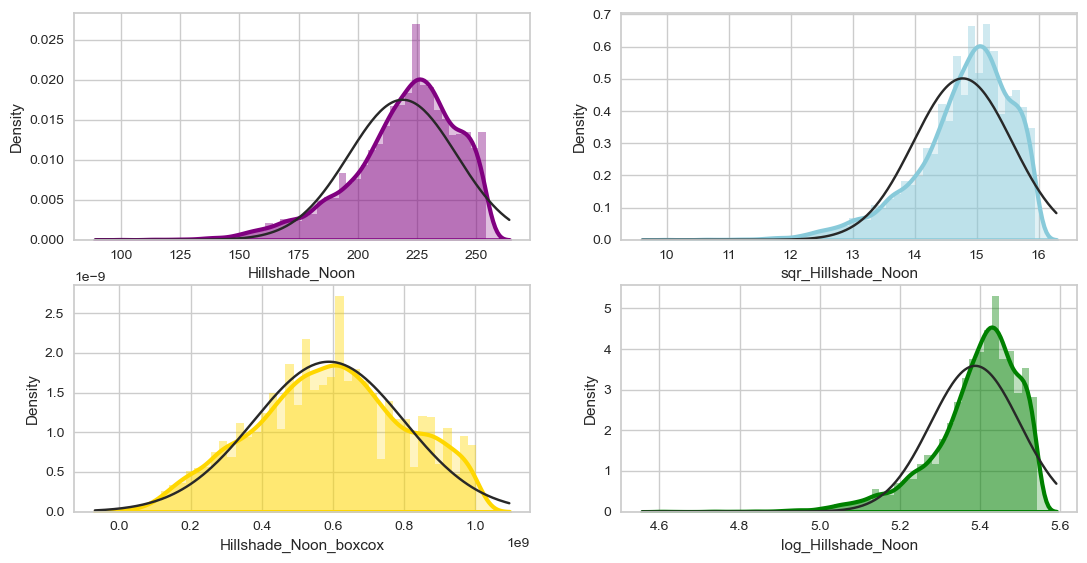

In [107]:
from scipy.stats import norm
import scipy.stats as stats

def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_train['Hillshade_Noon'], 'purple')
f.add_subplot(335)
histPlot(data_train['log_Hillshade_Noon'], 'green')
f.add_subplot(334)
histPlot(data_train['Hillshade_Noon_boxcox'], 'gold')                    
f.add_subplot(332)
histPlot(data_train['sqr_Hillshade_Noon'], 'c')

Box Coc is outperforming the other transformations for Hillshade Noon

In [108]:
data_train.drop(['log_Hillshade_Noon','sqr_Hillshade_Noon'], axis=1,inplace=True)

<a id='5.2.8.4'></a>
### <font color=green> 5.2.8.4 Hillshade 3pm <font>
#### <font color=green> Transformation  <font>

In [109]:
print('\033[95m'+"Skew before transformation\n", data_train['Hillshade_3pm'].skew(), 
      "\nmin\n", data_train['Hillshade_3pm'].min(),
      "\nmax\n", data_train['Hillshade_3pm'].max(),)

Skew before transformation
 -0.34082723258478564 
min
 0 
max
 248


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>, Square root Transformation<font color=gold> and BoxCox Transformation<font>

In [110]:
data_train['log_Hillshade_3pm'] = np.log(data_train['Hillshade_3pm']+1)

In [111]:
print('\033[92m'+"Skew after log transformation\n", data_train['log_Hillshade_3pm'].skew(), 
      "\nmin\n", data_train['log_Hillshade_3pm'].min(),
      "\nmax\n", data_train['log_Hillshade_3pm'].max(),)

Skew after log transformation
 -4.40025450334946 
min
 0.0 
max
 5.517452896464707


In [112]:
data_train['sqr_Hillshade_3pm'] = data_train['Hillshade_3pm']**0.5

In [113]:
print('\033[96m'+"Skew after Square Root transformation\n", data_train['sqr_Hillshade_3pm'].skew(), 
      "\nmin\n", data_train['sqr_Hillshade_3pm'].min(),
      "\nmax\n", data_train['sqr_Hillshade_3pm'].max(),)

Skew after Square Root transformation
 -1.338669485611021 
min
 0.0 
max
 15.748015748023622


In [114]:
#Now, the Box-Cox transformation also requires our data to only contain positive numbers, transform training data with Boxcox
data_train['Hillshade_3pm_boxcox'], lam  = stats.boxcox(data_train['Hillshade_3pm']+1)
#lam is the best lambda for the distribution

In [115]:
print('\033[93m'+"Skew after Boxcox transformation\n", data_train['Hillshade_3pm_boxcox'].skew(), 
      "\nmin\n", data_train['Hillshade_3pm_boxcox'].min(),
      "\nmax\n", data_train['Hillshade_3pm_boxcox'].max(),)

Skew after Boxcox transformation
 -0.15018383894899204 
min
 0.0 
max
 552.0141106428457


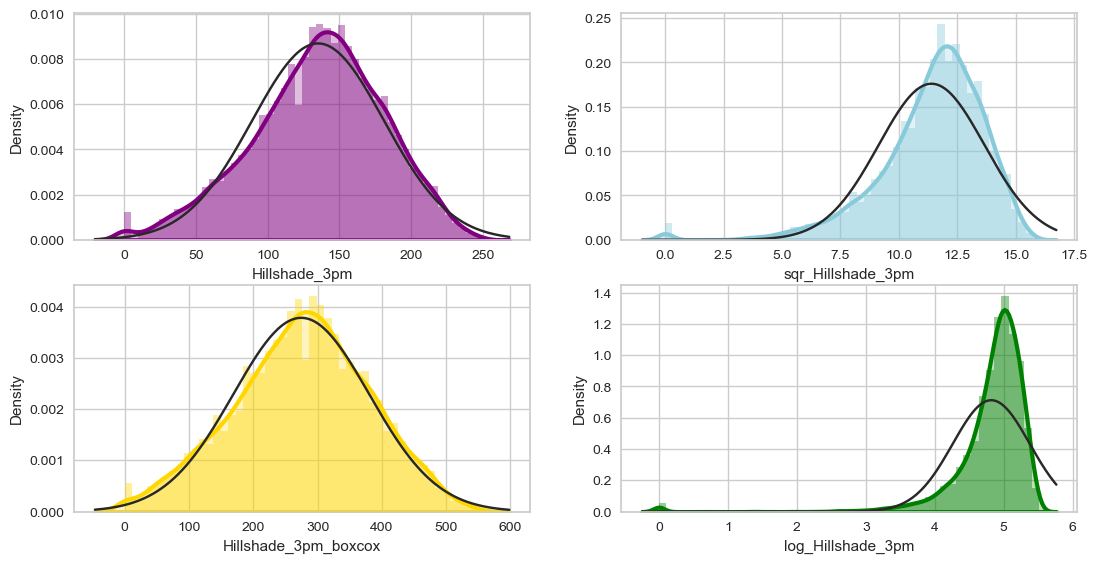

In [116]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_train['Hillshade_3pm'], 'purple')
f.add_subplot(335)
histPlot(data_train['log_Hillshade_3pm'], 'green')
f.add_subplot(334)
histPlot(data_train['Hillshade_3pm_boxcox'], 'gold')                    
f.add_subplot(332)
histPlot(data_train['sqr_Hillshade_3pm'], 'c')

For the Hillshade 3pm the data was not highly skwed, we either keep the original or we can use boxcox as it improved the variables as well. 

In [117]:
data_train.drop(['log_Hillshade_3pm','sqr_Hillshade_3pm'], axis=1,inplace=True)

<a id='5.2.8.5'></a>
### <font color=green> 5.2.8.5 Hillshades  Ratios <font>

In [118]:
data_train['ratio_Hillshade_3pm'] = data_train['Hillshade_3pm']/255
data_train['ratio_Hillshade_Noon'] = data_train['Hillshade_Noon']/255
data_train['ratio_Hillshade_9am'] = data_train['Hillshade_9am']/255

In [119]:
data_train['Hillshade_9am_bin'] = data_train['Hillshade_9am'] > 150
data_train['Hillshade_Noon_bin'] = data_train['Hillshade_Noon'] > 150
data_train['Hillshade_3pm_bin'] = data_train['Hillshade_3pm'] > 150

In [120]:
data_train['Hillshade_9am_bin'] = data_train['Hillshade_9am_bin'].astype(int)
data_train['Hillshade_Noon_bin'] = data_train['Hillshade_Noon_bin'].astype(int)
data_train['Hillshade_3pm_bin'] = data_train['Hillshade_3pm_bin'].astype(int)

In [121]:
data_train['Hillshade_allday_bin'] = data_train['Hillshade_9am_bin'] * data_train['Hillshade_Noon_bin'] * data_train['Hillshade_3pm_bin']

In [122]:
data_train['Hillshade_allday_bin'].value_counts()

0    9996
1    5124
Name: Hillshade_allday_bin, dtype: int64

<a id='5.2.8.6'></a>
### <font color=green> 5.2.8.6 Aspect <font>
#### <font color=green> Transformation  <font>

In [123]:
print('\033[95m'+"Skew before transformation\n", data_train['Aspect'].skew(), 
      "\nmin\n", data_train['Aspect'].min(),
      "\nmax\n", data_train['Aspect'].max(),)

Skew before transformation
 0.4509352940316223 
min
 0 
max
 360


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>and Square root Transformation<font>

In [124]:
data_train['sqr_Aspect'] = data_train['Aspect']**0.5

In [125]:
print('\033[96m'+"Skew after Square Root transformation\n", data_train['sqr_Aspect'].skew(), 
      "\nmin\n", data_train['sqr_Aspect'].min(),
      "\nmax\n", data_train['sqr_Aspect'].max(),)

Skew after Square Root transformation
 -0.1265330594721135 
min
 0.0 
max
 18.973665961010276


In [126]:
data_train['log_Aspect'] = np.log(data_train['Aspect']+1)

In [127]:
print('\033[92m'+"Skew after log transformation\n", data_train['log_Aspect'].skew(), 
      "\nmin\n", data_train['log_Aspect'].min(),
      "\nmax\n", data_train['log_Aspect'].max(),)

Skew after log transformation
 -1.4584406899303897 
min
 0.0 
max
 5.8888779583328805


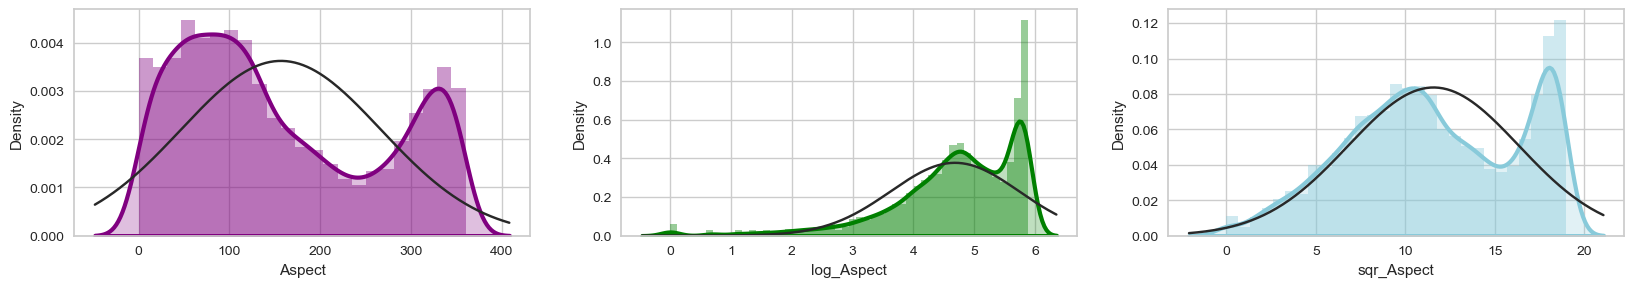

In [128]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_train['Aspect'], 'purple')
f.add_subplot(332)
histPlot(data_train['log_Aspect'], 'green')
#f.add_subplot(334)
#histPlot(data_train['Hillshade_3pm_boxcox'], 'gold')                    
f.add_subplot(333)
histPlot(data_train['sqr_Aspect'], 'c')

For aspect square root turned out to be the best transformation in terms of skeweness. 

Overall, the best transformations done here are square rt, and boxcox. log transformations did not proved to be benefitial

In [129]:
data_train.drop(['log_Aspect'], axis=1,inplace=True)

In here we are transforming the ratios into a unit scale by dividing by its index. We do so because we think it is much easier to understand

In [130]:
data_train['ratio_Hillshade_3pm'] = data_train['Hillshade_3pm']/255
data_train['ratio_Hillshade_Noon'] = data_train['Hillshade_Noon']/255
data_train['ratio_Hillshade_9am'] = data_train['Hillshade_9am']/255


<a id='5.2.8.7'></a>
### <font color=green> 5.2.8.7 Aspect in degrees <font>
### <font color=green> New Features  <font>
The azimuth is the angular direction of the sun, measured from north clockwise in degrees from 0 to 360. An Azimuth of 90 degrees is east.The Cut of values will be between for instance the middle of north and east.
    
We make a transformation so to get dummies for Aspect ordinal values: north, south, east and west

* Aspect_North: from 315 deg to 45 deg
* Aspect_East: from 45 deg to 135 deg
* Aspect_South: from 135 deg to 225 deg
* Aspect_West: from 225 deg to 315 deg    

<img src="angle_azimuth.png" width=400 height=200 align="center">
    
Source:https://www.pveducation.org/pvcdrom/properties-of-sunlight/azimuth-angle

In [131]:
#Grouping Aspect in the four directions
data_train['Aspect_North']=  np.where(((data_train['Aspect']>=0) & (data_train['Aspect']<45))|((X_train['Aspect']>=315) & (X_train['Aspect']<=360)), 1 ,0)
data_train['Aspect_East']= np.where((data_train['Aspect']>=45) & (data_train['Aspect']<135), 1 ,0)
data_train['Aspect_South']= np.where((data_train['Aspect']>=135) & (data_train['Aspect']<225), 1 ,0)
data_train['Aspect_West']= np.where((data_train['Aspect']>=225) & (data_train['Aspect']<315), 1 ,0)


<a id='5.2.8.8'></a>
### <font color=green> 5.2.8.8 Elevation <font>

No transformation is done as it is already very symetric distributed 


In [132]:
print('\033[95m'+"Skew before transformation\n", data_train['Elevation'].skew(), 
      "\nmin\n", data_train['Elevation'].min(),
      "\nmax\n", data_train['Elevation'].max(),)

Skew before transformation
 0.07563970693591461 
min
 1863 
max
 3849


In [133]:
data_train['binned_elevation'] = [math.floor(v/50.0) for v in data_train['Elevation']]

We are making more features byt summing and substracing different combinations similar in terms of units

Addition and Substraction on the same scale
Using for loop was giving us a bad performance hence we are using the features on the same scale which to add or substract 

In [134]:
data_train['Road+Fire'] = data_train['Horizontal_Distance_To_Roadways'] + data_train['Horizontal_Distance_To_Fire_Points']
data_train['Road-Fire'] = abs(data_train['Horizontal_Distance_To_Roadways'] - data_train['Horizontal_Distance_To_Fire_Points'])
data_train['Road+Hydro'] = data_train['Horizontal_Distance_To_Roadways'] + data_train['Horizontal_Distance_To_Hydrology']
data_train['Road-Hydro'] = abs(data_train['Horizontal_Distance_To_Roadways'] - data_train['Horizontal_Distance_To_Hydrology'])
data_train['Hydro+Fire'] = data_train['Horizontal_Distance_To_Hydrology'] + data_train['Horizontal_Distance_To_Fire_Points']
data_train['Hydro-Fire'] = abs(data_train['Horizontal_Distance_To_Hydrology'] - data_train['Horizontal_Distance_To_Fire_Points'])

data_train['Road+Fire+Hydro'] = data_train['Horizontal_Distance_To_Roadways']  + data_train['Horizontal_Distance_To_Fire_Points'] + data_train['Horizontal_Distance_To_Hydrology']

data_train['Ele+Road+Fire+Hydro'] = data_train['Elevation'] + data_train['Horizontal_Distance_To_Roadways']  + data_train['Horizontal_Distance_To_Fire_Points'] + data_train['Horizontal_Distance_To_Hydrology']

data_train['Ele+road'] = data_train['Elevation'] + data_train['Horizontal_Distance_To_Roadways']
data_train['Ele-road'] = abs(data_train['Elevation'] - data_train['Horizontal_Distance_To_Roadways'])
data_train['Ele+fire'] = data_train['Elevation'] + data_train['Horizontal_Distance_To_Fire_Points']
data_train['Ele-fire'] = abs(data_train['Elevation'] - data_train['Horizontal_Distance_To_Fire_Points'])
data_train['Ele+hydro'] = data_train['Elevation'] + data_train['Horizontal_Distance_To_Hydrology']
data_train['Ele-hydro'] = abs(data_train['Elevation'] - data_train['Horizontal_Distance_To_Hydrology'])

### <font color=green> 5.2.9 Geoclimate grouping  <font>

#### <font color=green> 5.2.9.1 Climatic feature engineering to group soils  <font>

In the Kaggle competition, there is a reference to John A. Blackard which happened to be one geologist working for the forest federal US agency. In a co-authored paper, he gives further insights on the soil families with a list of codes. These are digits categorizing the soils according to climate and geology. We decide to take this valuable insight and engineer features around this dynamic so to cut down the number of soils

From original database donated by John A. Blackard

Code Designations:

Wilderness Areas:  	<br>

1 - Rawah Wilderness Area <br>
2 - Neota Wilderness Area  <br>
3 - Comanche Peak Wilderness Area<br>
4 - Cache la Poudre Wilderness Area<br>

Soil Types:             1 to 40 : based on the USFS Ecological
                        Landtype Units (ELUs) for this study area:<br>

  Study Code USFS ELU Code			Description<br>
	 1	   2702		Cathedral family - Rock outcrop complex, extremely stony.<br>
	 2	   2703		Vanet - Ratake families complex, very stony.<br>
	 3	   2704		Haploborolis - Rock outcrop complex, rubbly.<br>
	 4	   2705		Ratake family - Rock outcrop complex, rubbly.<br>
	 5	   2706		Vanet family - Rock outcrop complex complex, rubbly.<br>
	 6	   2717		Vanet - Wetmore families - Rock outcrop complex, stony.<br>
	 7	   3501		Gothic family.<br>
	 8	   3502		Supervisor - Limber families complex.<br>
	 9	   4201		Troutville family, very stony.<br>
	10	   4703		Bullwark - Catamount families - Rock outcrop complex, rubbly.<br>
	11	   4704		Bullwark - Catamount families - Rock land complex, rubbly.<br>
	12	   4744		Legault family - Rock land complex, stony.<br>
	13	   4758		Catamount family - Rock land - Bullwark family complex, rubbly.<br>
	14	   5101		Pachic Argiborolis - Aquolis complex.<br>
	15	   5151		unspecified in the USFS Soil and ELU Survey.<br>
	16	   6101		Cryaquolis - Cryoborolis complex.<br>
	17	   6102		Gateview family - Cryaquolis complex.<br>
	18	   6731		Rogert family, very stony.<br>
	19	   7101		Typic Cryaquolis - Borohemists complex.<br>
	20	   7102		Typic Cryaquepts - Typic Cryaquolls complex.<br>
	21	   7103		Typic Cryaquolls - Leighcan family, till substratum complex.<br>
	22	   7201		Leighcan family, till substratum, extremely bouldery.<br>
	23	   7202		Leighcan family, till substratum - Typic Cryaquolls complex.<br>
	24	   7700		Leighcan family, extremely stony.<br>
	25	   7701		Leighcan family, warm, extremely stony.<br>
	26	   7702		Granile - Catamount families complex, very stony.<br>
	27	   7709		Leighcan family, warm - Rock outcrop complex, extremely stony.<br>
	28	   7710		Leighcan family - Rock outcrop complex, extremely stony.<br>
	29	   7745		Como - Legault families complex, extremely stony.<br>
	30	   7746		Como family - Rock land - Legault family complex, extremely stony.<br>
	31	   7755		Leighcan - Catamount families complex, extremely stony.<br>
	32	   7756		Catamount family - Rock outcrop - Leighcan family complex, extremely stony.<br>
	33	   7757		Leighcan - Catamount families - Rock outcrop complex, extremely stony.<br>
	34	   7790		Cryorthents - Rock land complex, extremely stony.<br>
	35	   8703		Cryumbrepts - Rock outcrop - Cryaquepts complex.<br>
	36	   8707		Bross family - Rock land - Cryumbrepts complex, extremely stony.<br>
	37	   8708		Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.<br>
	38	   8771		Leighcan - Moran families - Cryaquolls complex, extremely stony.<br>
	39	   8772		Moran family - Cryorthents - Leighcan family complex, extremely <br>stony.
	40	   8776		Moran family - Cryorthents - Rock land complex, extremely stony.<br>

        Note:   First digit:  climatic zone       Second digit:  geologic zones
                1.  lower montane dry             1.  alluvium
                2.  lower montane                 2.  glacial
                3.  montane dry                   3.  shale
                4.  montane                       4.  sandstone
                5.  montane dry and montane       5.  mixed sedimentary
                6.  montane and subalpine         6.unspecified in the USFS ELU Survey
                7.  subalpine                     7.  igneous and metamorphic
                8.  alpine                        8.  volcanic

The USFD, an American federal agency for forest service dependent on the department of agriculture has classified soil types according to __climatic zone (first digit)__ and __geology (second digit)__. Because of this, we believe a similar classification can be artificially engineered grouping all similar soils in 7 categories for climate (there is no lower montane dry soils) and 4 for geology (we do not take into consideration shale, sandstone, volcanic or unspecified)

#### <font color=green> 5.2.9.2 Climatic Zone feature engineering to group soils  <font>

In [135]:
data_train["Lower_Montane_Climate"] = data_train.loc[:,data_train.columns.str.contains("^Soil_Type[23456]$")].max(axis=1)

In [136]:
data_train['Montane_Dry_Climate'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type[78]$")].max(axis=1)

In [137]:
data_train['Montane_Climate'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type[1][0123]$|Soil_Type[9]$")].max(axis=1)

In [138]:
data_train['Montane_Dry_and_Montane_Climate'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type[1][45]$")].max(axis=1)

In [139]:
data_train['Montante_and_Subalpine_Climate'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type[1][678]$")].max(axis=1)


In [140]:
data_train['Subalpine_Climate'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type19$|^Soil_Type[2][0-9]$|^Soil_Type[3][0-4]$")].max(axis=1)


In [141]:
data_train['Alpine_Climate'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type[3][56789]$|Soil_Type40")].max(axis=1)

#### <font color=green> 5.2.9.2 Geological feature engineering to group soils  <font>

        Note:   First digit:  climatic zone             Second digit:  geologic zones
                1.  lower montane dry                   1.  alluvium
                2.  lower montane                       2.  glacial
                3.  montane dry                         3.  shale
                4.  montane                             4.  sandstone
                5.  montane dry and montane             5.  mixed sedimentary
                6.  montane and subalpine               6.  unspecified in the USFS ELU Survey
                7.  subalpine                           7.  igneous and metamorphic
                8.  alpine                              8.  volcanic

In [142]:
data_train['Alluvium_Soil'] = data_train.loc[:,data_train.columns.str.contains("^Soil_Type[1][45679]$|^Soil_Type[2][01]$")].max(axis=1)

In [143]:
data_train['Glacial_Soil'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type[9]$|^Soil_Type[2][23]$")].max(axis=1)

In [144]:
data_train['Mixed_Sedimentary_Soil'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type[7-8]$")].max(axis=1)

In [145]:
data_train['Igneus_and_Metamorphic_Soil'] =data_train.loc[:,data_train.columns.str.contains("^Soil_Type[1-6]$|^Soil_Type[1][01238]$|^Soil_Type[3-4]\d$|^Soil_Type[2][4-9]$")].max(axis=1)

In [146]:
data_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Distance_To_Hydrology,sqr_Distance_To_Hydrology,Sqr_Horizontal_Distance_To_Roadways,SqrSlope,sqr_Horizontal_Distance_To_firepoints,Mean_Hillshade,Mean_Hillshade_bin,Mean_Hillshade_boxcox,Hillshade_9am_boxcox,Hillshade_Noon_boxcox,Hillshade_3pm_boxcox,ratio_Hillshade_3pm,ratio_Hillshade_Noon,ratio_Hillshade_9am,Hillshade_9am_bin,Hillshade_Noon_bin,Hillshade_3pm_bin,Hillshade_allday_bin,sqr_Aspect,Aspect_North,Aspect_East,Aspect_South,Aspect_West,binned_elevation,Road+Fire,Road-Fire,Road+Hydro,Road-Hydro,Hydro+Fire,Hydro-Fire,Road+Fire+Hydro,Ele+Road+Fire+Hydro,Ele+road,Ele-road,Ele+fire,Ele-fire,Ele+hydro,Ele-hydro,Lower_Montane_Climate,Montane_Dry_Climate,Montane_Climate,Montane_Dry_and_Montane_Climate,Montante_and_Subalpine_Climate,Subalpine_Climate,Alpine_Climate,Alluvium_Soil,Glacial_Soil,Mixed_Sedimentary_Soil,Igneus_and_Metamorphic_Soil
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,132396,7788,669768,0,1323960,573716,602272,384208,16300284,153,13158,0,26010,11271,11832,7548,320229,774,0,1530,663,696,444,18837,0,131580,57018,59856,38184,1619982,0,0,0,0,0,112710,118320,75480,3202290,51272,32708,1387659,34336,1456728,929292,258.000000,16.062378,22.583180,1.732051,79.240141,200.333333,2.0,2.720721e+11,8.911160e+07,6.997710e+08,301.766934,0.580392,0.909804,0.866667,1,1,0,0,7.141428,0,1

Based on the medium paper "Preprocessing: Why you should generate polynominal features first before standardizing" mention it is not good practice to standardize the variablesbefore before PolynominalFeatures. This should be done after to not loss the signal of the variables.  

In [147]:
# Identify and drop our target variable 'Cover_Type' from dataframe, isolating our independent variables
X = data_train.drop('Cover_Type', axis = 1)

# Isolate our dependent variable as a feature
y = data_train['Cover_Type']

In [148]:
# Train Test Split (80/20 size), drop duplicates and missing values


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 37, stratify=y)

X_train.drop_duplicates(inplace = True)
X_train.dropna(inplace = True)

C:\Users\Pedro\AppData\Local\Temp\ipykernel_338508\497851878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop_duplicates(inplace = True)
C:\Users\Pedro\AppData\Local\Temp\ipykernel_338508\497851878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.dropna(inplace = True)


### Advanced Factorization

The numerical values present a level of detail that may be much more fine-grained than we need. For instance, the soil level can be represented by different categories (soil family, complex or stony/rubberly). We aggregate the data up which can help to avoid overfitting when the data is more aggregate.

__We played with these features but reached a final conclusion of not to considering any more families and complex type. But Stonyness,climate and geogology. For purposes of the assignment we show the code as a RAWNBCONVERT__

The only family grouping we do on soils are the ones above, on geological and climate grounds

### <font color=green> 5.6 Soil Type Family  <font>

Using Discretization to bin the soil variable to the family type.<br>

__Cathedral__ <br>
1 Cathedral family - Rock outcrop complex, extremely stony.<br>

__Ratake__ <br>
2 Vanet - Ratake families complex, very stony.<br>
4 Ratake family - Rock outcrop complex, rubbly.<br>

__Vanet__<br>
5 Vanet family - Rock outcrop complex complex, rubbly.<br>

__Wetmore__<br>
6 Vanet - Wetmore families - Rock outcrop complex, stony.<br>

__Gothic__<br>
7 Gothic family.<br>
                    
__Limber__ <br>
8 Supervisor - Limber families complex. <br>

__Troutville__<br>
9 Troutville family, very stony.<br>

__Legault__<br>
12 Legault family - Rock land complex, stony.<br>
29 Como - Legault families complex, extremely stony.<br>

__Gateview__ <br>
17 Gateview family - Cryaquolis complex.<br>

__Rogert__<br>
18 Rogert family, very stony.<br>


__Como__<br>
30 Como family - Rock land - Legault family complex, extremely stony.<br>

__Bross__<br>
36 Bross family - Rock land - Cryumbrepts complex, extremely stony.<br>



__Catamount__<br>
10 Bullwark - Catamount families - Rock outcrop complex, rubbly.<br>
11 Bullwark - Catamount families - Rock land complex, rubbly.<br>
13 Catamount family - Rock land - Bullwark family complex, rubbly.<br>
26 Granile - Catamount families complex, very stony.<br>
32 Catamount family - Rock outcrop - Leighcan family complex, extremely stony.<br>
31 Leighcan - Catamount families complex, extremely stony.<br>
33 Leighcan - Catamount families - Rock outcrop complex, extremely stony.<br>

__Leighcan__<br>
21 Typic Cryaquolls - Leighcan family, till substratum complex.<br>
22 Leighcan family, till substratum, extremely bouldery.<br>
23 Leighcan family, till substratum - Typic Cryaquolls complex.<br>
24 Leighcan family, extremely stony.<br>
25 Leighcan family, warm, extremely stony.<br>
27 Leighcan family, warm - Rock outcrop complex, extremely stony.<br>
28 Leighcan family - Rock outcrop complex, extremely stony.<br>

__Moran__<br>
38 Leighcan - Moran families - Cryaquolls complex, extremely stony.<br>
39 Moran family - Cryorthents - Leighcan family complex, extremely stony.<br>
40 Moran family - Cryorthents - Rock land complex, extremely stony.<br>

__Others__<br> 
3 Haploborolis - Rock outcrop complex, rubbly.<br>
15 unspecified in the USFS Soil and ELU Survey.<br>
37 Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.<br>
34 Cryorthents - Rock land complex, extremely stony.<br>
35 Cryumbrepts - Rock outcrop - Cryaquepts complex.<br>
20 Typic Cryaquepts - Typic Cryaquolls complex.<br>
14 Pachic Argiborolis - Aquolis complex.<br>
16 Cryaquolis - Cryoborolis complex.<br>
19 Typic Cryaquolis - Borohemists complex.<br>

__NOT USED__

We will group the soil types according to their family and according to the complex and stonyness

Complex Group <br>
__Rock_outcrop_complex__ <br>
1 Cathedral family - Rock outcrop complex, extremely stony.<br>
2 Vanet - Ratake families complex, very stony.<br>
3 Haploborolis - Rock outcrop complex, rubbly.<br>
4 Ratake family - Rock outcrop complex, rubbly.<br>
5 Vanet family - Rock outcrop complex complex, rubbly.<br>
6 Vanet - Wetmore families - Rock outcrop complex, stony.<br>
10 Bullwark - Catamount families - Rock outcrop complex, rubbly.<br>
27 Leighcan family, warm - Rock outcrop complex, extremely stony.<br>
28 Leighcan family - Rock outcrop complex, extremely stony.<br>
33 Leighcan - Catamount families - Rock outcrop complex, extremely stony.<br>

__Ratake_families_complex__<br>
2 Vanet - Ratake families complex, very stony.<br>


__Limber families complex__<br>
8 Supervisor - Limber families complex.<br>

__rock land complex__<br>
11 Bullwark - Catamount families - Rock land complex, rubbly.<br>
12 Legault family - Rock land complex, stony.<br>
34 Cryorthents - Rock land complex, extremely stony.<br>
40 Moran family - Cryorthents - Rock land complex, extremely stony.<br>

__Cryoborolis complex__<br>
16 Cryaquolis - Cryoborolis complex.<br>
17 Gateview family - Cryaquolis complex.<br>

__Bullwark family complex__<br>
13 Catamount family - Rock land - Bullwark family complex, rubbly.<br>

__Aquolis complex__<br>
14 Pachic Argiborolis - Aquolis complex.<br>

__Borohemists complex__<br>
19 Typic Cryaquolis - Borohemists complex.<br>

__Cryaquolls complex__<br>
20 Typic Cryaquepts - Typic Cryaquolls complex.<br>
23 Leighcan family, till substratum - Typic Cryaquolls complex.<br>
38 Leighcan - Moran families - Cryaquolls complex, extremely stony.<br>

__till substratum complex__<br>
21 Typic Cryaquolls - Leighcan family, till substratum complex.<br>

__Catamount families complex__<br>
26 Granile - Catamount families complex, very stony.<br>
1 Leighcan - Catamount families complex, extremely stony.<br>
31 Leighcan - Catamount families complex, extremely stony.<br>

__Legault families complex__<br>
29 Como - Legault families complex, extremely stony.<br>
30 Como family - Rock land - Legault family complex, extremely stony.<br>

__Leighcan family complex__<br>
32 Catamount family - Rock outcrop - Leighcan family complex, extremely stony.<br>
39 Moran family - Cryorthents - Leighcan family complex, extremely stony.<br>

__Cryaquepts complex__<br>
35 Cryumbrepts - Rock outcrop - Cryaquepts complex.<br>

__Cryumbrepts complex__<br>
36 Bross family - Rock land - Cryumbrepts complex, extremely stony.<br>

__Cryorthents complex__<br>
37 Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.<br>

__others__ <br>
7 Gothic family.<br>
9 Troutville family, very stony.<br>
22 Leighcan family, till substratum, extremely bouldery.<br>
24 Leighcan family, extremely stony.<br>
25 Leighcan family, warm, extremely stony.<br>
18 Rogert family, very stony.<br>
15 unspecified in the USFS Soil and ELU Survey.<br>


Source: https://www.kaggle.com/competitions/forest-cover-type-prediction/data

__NOT USED__

__Stony__ <br>
1 Cathedral family - Rock outcrop complex, extremely stony.<br>
2 Vanet - Ratake families complex, very stony.<br>
6 Vanet - Wetmore families - Rock outcrop complex, stony.<br>
9 Troutville family, very stony.<br>
12 Legault family - Rock land complex, stony.<br>
18 Rogert family, very stony.<br>
24 Leighcan family, extremely stony.<br>
25 Leighcan family, warm, extremely stony.<br>
26 Granile - Catamount families complex, very stony.<br>
27 Leighcan family, warm - Rock outcrop complex, extremely stony.<br>
28 Leighcan family - Rock outcrop complex, extremely stony.<br>
29 Como - Legault families complex, extremely stony.<br>
30 Como family - Rock land - Legault family complex, extremely stony.<br>
31 Leighcan - Catamount families complex, extremely stony.<br>
32 Catamount family - Rock outcrop - Leighcan family complex, extremely stony.<br>
33 Leighcan - Catamount families - Rock outcrop complex, extremely stony.<br>
34 Cryorthents - Rock land complex, extremely stony.<br>
36 Bross family - Rock land - Cryumbrepts complex, extremely stony.<br>
37 Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.<br>
38 Leighcan - Moran families - Cryaquolls complex, extremely stony.<br>
39 Moran family - Cryorthents - Leighcan family complex, extremely stony.<br>
40 Moran family - Cryorthents - Rock land complex, extremely stony.<br>

__Rubbly__<br>
3 Haploborolis - Rock outcrop complex, rubbly.<br>
4 Ratake family - Rock outcrop complex, rubbly.<br>
5 Vanet family - Rock outcrop complex complex, rubbly.<br>
10 Bullwark - Catamount families - Rock outcrop complex, rubbly.<br>
11 Bullwark - Catamount families - Rock land complex, rubbly.<br>
13 Catamount family - Rock land - Bullwark family complex, rubbly.<br>

__others__<br>
7 Gothic family.<br>
8 Supervisor - Limber families complex.<br>
14 Pachic Argiborolis - Aquolis complex.<br>
15 unspecified in the USFS Soil and ELU Survey.<br>
16 Cryaquolis - Cryoborolis complex.<br>
17 Gateview family - Cryaquolis complex.<br>
19 Typic Cryaquolis - Borohemists complex.<br>
20 Typic Cryaquepts - Typic Cryaquolls complex.<br>
21 Typic Cryaquolls - Leighcan family, till substratum complex.<br>
22 Leighcan family, till substratum, extremely bouldery.<br>
23 Leighcan family, till substratum - Typic Cryaquolls complex.<br>
35 Cryumbrepts - Rock outcrop - Cryaquepts complex.<br>

__This has been included__

Note: Soil type is a single variable which has been one-hot encoded presumably , so we will reverse engineer the soil type. We will eventually drop the original soil type columns which has the added effect of significantly reducing the total number of features.

In [149]:
# Original soil features
soil_features = [f'Soil_Type{i}' for i in range(1,41)]

In [150]:
# Drop original soil features
data_train.drop(columns = soil_features, inplace = True)

In [151]:
#test if elevation makes a difference to take out with the new interaction model improves
#data_train = data_train.drop(['Elevation^2'], axis = 1)
data_train = data_train.drop(['Elevation'], axis = 1)

In [152]:
data_train

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Distance_To_Hydrology,sqr_Distance_To_Hydrology,Sqr_Horizontal_Distance_To_Roadways,SqrSlope,sqr_Horizontal_Distance_To_firepoints,Mean_Hillshade,Mean_Hillshade_bin,Mean_Hillshade_boxcox,Hillshade_9am_boxcox,Hillshade_Noon_boxcox,Hillshade_3pm_boxcox,ratio_Hillshade_3pm,ratio_Hillshade_Noon,ratio_Hillshade_9am,Hillshade_9am_bin,Hillshade_Noon_bin,Hillshade_3pm_bin,Hillshade_allday_bin,sqr_Aspect,Aspect_North,Aspect_East,Aspect_South,Aspect_West,binned_elevation,Road+Fire,Road-Fire,Road+Hydro,Road-Hydro,Hydro+Fire,Hydro-Fire,Road+Fire+Hydro,Ele+Road+Fire+Hydro,Ele+road,Ele-road,Ele+fire,Ele-fire,Ele+hydro,Ele-hydro,Lower_Montane_Climate,Montane_Dry_Climate,Montane_Climate,Montane_Dry_and_Montane_Climate,Montante_and_Subalpine_Climate,Subalpine_Climate,Alpine_Climate,Alluvium_Soil,Glacial_Soil,Mixed_Sedimentary_Soil,Igneus_and_Metamorphic_Soil
0,51,3,258,0,510,221,232,148,6279,1,0,0,0,5,132396,7788,669768,0,1323960,573716,602272,384208,16300284,153,13158,0,26010,11271,11832,7548,320229,774,0,1530,663,696,444,18837,0,131580,57018,59856,38184,1619982,0,0,0,0,0,112710,118320,75480,3202290,51272,32708,1387659,34336,1456728,929292,258.000000,16.062378,22.583180,1.732051,79.240141,200.333333,2.0,2.720721e+11,8.911160e+07,6.997710e+08,301.766934,0.580392,0.909804,0.866667,1,1,0,0,7.141428,0,1,0,0,51,6789,5769,768,252,6537,6021,7047,9643,3106,2086,8875,3683,2854,2338,0,0,0,0,0,1,0,0,0,0,1
1,56,2,212,-6,390,220,235,151,6225,1,0,0,0,5,145040,5180,549080,-15540,1010100,569800,608650,391090,16122750,112,11872,-336,21840,12320,13160,8456,348600,424,-12,780,440,470,302,12450,-1272,82680,46640,49820,32012,1319700,-2340,-1320,-1410,-906,-37350,85800,91650,58890,2427750,51700,33220,1369500,35485,1462875,939975,212.084889,14.563135,19.748418,1.414214,78.898669,202.000000,2.0,2.842424e+11,8.766444e+07,7.366116e+08,308.929988,0.592157,0.921569,0.862745,1,1,1,1

Removing the original scaled variables did not improve nor worsen the model. Since it does not change much the score, we remove it as we have it double in the model with the scaled features. 

In [153]:
data_train= data_train.drop(['Aspect','Slope','Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points'], axis = 1)

In [154]:
X_drop =data_train.drop(labels=["Cover_Type"],axis=1)
y_drop =data_train ['Cover_Type']

In [155]:
X_train_drop,X_val_drop,y_train_drop,y_val_drop = train_test_split (X_drop,y_drop,random_state=37) #seed is 37

In [156]:
forest_dropped_variables = RandomForestClassifier(random_state=37)
model_dropped_variables = forest_dropped_variables.fit(X_train_drop,y_train_drop)

In [157]:
# calculating accuracy_score
model_dropped_variables.score(X_val_drop,y_val_drop)

0.8603174603174604

In [158]:
forest_dropped_variables = RandomForestClassifier(random_state=37)
print("Accuracy = {0:.4f}".format(np.mean(cross_val_score(model_dropped_variables, X_val_drop, y_val_drop))))

Accuracy = 0.7989


Model does not improve with respect to baseline's 80%

### <font color=green> 5.10 Summary <font>

<table>
  <tr>
    <th><b>Features</b></th>
    <th><b>Transformation</b></th>
  </tr>
  <tr>
<td>ID  </td>
    <td> Drop</td>
  </tr>
  <tr>
    <td>Distance To Hydrology  </td>
    <td><b><i>Square Root</i></b> of the length of the side of horizontal and vertical </td>
  </tr>
  <tr>
    <td>Horizontal Distance To Roadways</td>
    <td><b>Square Root</b> of horizontal Distance to Roadways</td>
  </tr>
  <tr>
    <td> Slope</td>
    <td><b><i>Square Root</i></b> Slope</td>
  </tr>
  <tr>
    <td> Horizontal_Distance To firepoints</td>
    <td><b><i>Square Root</i></b> Horizontal Distance to firepoints</td>
  </tr>
  <tr>
    <td>Mean Hillshade</td>
    <td><b><i>Box Cox Average</i></b> of all Hillshades features</td>
  <tr>      
  </tr>
    <td>Hillshade 9am</td>
    <td><b><i>Box Cox </i></b> Hillshade 9am</td>
  <tr>      
  </tr>
    <td>Hillshade Noon</td>
    <td><b><i>Box Cox </i></b> Hillshade Noon</td>
  <tr>      
  </tr>
    <td>Hillshade 3pm</td>
    <td><b><i>Box Cox</i></b> Hillshade 3pm</td>
  <tr>      
  </tr>
        <td>Aspect</td>
    <td><b><i>Square Root</i></b> Aspect</td>
  <tr>      
  </tr>
    <td>Aspect North, East,South and West</td>
    <td><b><i>Grouping</i></b> Aspect</td>
  <tr>      
  </tr>
    <td>Geological Grouping</td>
    <td><b><i>Grouping</i></b> Soil Types</td>
  <tr>      
  </tr>
    <td>Climate Grouping</td>
    <td><b><i>Grouping</i></b> Soil Types</td>
  <tr>      
  </tr>
     <td>Soil Family</td>
    <td><b><i>Grouping</i></b> Soil Families</td>
  <tr>      
  </tr>
     <td>Soil Type Complex</td>
    <td><b><i>Grouping</i></b> Soil Complex</td>
  <tr>      
  </tr> 
     <td>Soil Type Stonyness</td>
    <td><b><i>Grouping</i></b> by Soil stonyness</td>
  <tr>      
  </tr>     

</table>

<a id='6'></a>
# <font color=green> 6.Feature Selection <font>


We will try to use several feature selection algorithms where we use them in combination of all the different selection method and will take the best score of all the used common algorithms score. 

Source: https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2 

### Locking all features in a csv

For the shake of efficiency, we create a csv file to reuse also later on in part III

In [159]:
data_train.shape

(15120, 99)

This code below have all features that we did in the feature engineering part and transport this to csv before we actually use the feature selection methods and select only few variables. 

In [160]:
#Only X_Train replacement
data_train.to_csv('all_features_data_train.csv')
data_train.to_csv('all_features_data_train.csv') #this one is doubled

<a id='6.1'></a>
## <font color=green> 6.1. Standardization <font>

We now proceed to do some standardization in the hopes it will help assist feature selection algorithms more efficiently.

We attempt also to run a few correlation matrices and take out heavily correlated values but this did not improved baselines' accuracy so it is marked as RAWNBCONVERT

__NOT USED__

We can barely see anything but I'd remove all green blocks (polynomial features)

__NOT USED__

Green correlations are still there, I do another drop

__NOT USED__

Doing an extra round of drops

__NOT USED__

Now removing perfect colinearity 1s

__NOT USED__

We __split__ the dataset to train and validation set, in order to test our models. We use stratify to have a balanced dataset with regards to y predictor

In [161]:
X = data_train.drop(['Cover_Type'], axis=1)
y = data_train['Cover_Type']
column_list = X.columns

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=37,stratify=y)
print("The shape of validation data:{} and {} ".format(X_val.shape,y_val.shape))
print("The shape of training data:{} and {} ".format(X_train.shape,y_train.shape))

The shape of validation data:(3024, 98) and (3024,) 
The shape of training data:(12096, 98) and (12096,) 


For the standardization we need only numerical values, since these has been aleady encoded we use the names to filter out the dummy variables 

In [162]:
scale_numerical  = [column for column in column_list if 'Soil' not in column and 'Wilderness_Area' not in  column and 'Aspect_North' not in  column and 'Climate' not in  column and 'Family' not in  column and 'Type' not in  column and 'complex' not in  column and 'Aspect_East' not in  column and 'Aspect_South' not in  column and 'Aspect_West' not in  column ]
scale_categorial= [column for column in column_list if column not in scale_numerical ]

In [163]:
scale_numerical

['Elevation_x_Aspect',
 'Elevation_x_Slope',
 'Elevation_x_Horizontal_Distance_To_Hydrology',
 'Elevation_x_Vertical_Distance_To_Hydrology',
 'Elevation_x_Horizontal_Distance_To_Roadways',
 'Elevation_x_Hillshade_9am',
 'Elevation_x_Hillshade_Noon',
 'Elevation_x_Hillshade_3pm',
 'Elevation_x_Horizontal_Distance_To_Fire_Points',
 'Aspect_x_Slope',
 'Aspect_x_Horizontal_Distance_To_Hydrology',
 'Aspect_x_Vertical_Distance_To_Hydrology',
 'Aspect_x_Horizontal_Distance_To_Roadways',
 'Aspect_x_Hillshade_9am',
 'Aspect_x_Hillshade_Noon',
 'Aspect_x_Hillshade_3pm',
 'Aspect_x_Horizontal_Distance_To_Fire_Points',
 'Slope_x_Horizontal_Distance_To_Hydrology',
 'Slope_x_Vertical_Distance_To_Hydrology',
 'Slope_x_Horizontal_Distance_To_Roadways',
 'Slope_x_Hillshade_9am',
 'Slope_x_Hillshade_Noon',
 'Slope_x_Hillshade_3pm',
 'Slope_x_Horizontal_Distance_To_Fire_Points',
 'Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_

In [164]:
X_train[scale_numerical]

,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Distance_To_Hydrology,sqr_Distance_To_Hydrology,Sqr_Horizontal_Distance_To_Roadways,SqrSlope,sqr_Horizontal_Distance_To_firepoints,Mean_Hillshade,Mean_Hillshade_bin,Mean_Hillshade_boxcox,Hillshade_9am_boxcox,Hillshade_Noon_boxcox,Hillshade_3pm_boxcox,ratio_Hillshade_3pm,ratio_Hillshade_Noon,ratio_Hillshade_9am,Hillshade_9am_bin,Hillshade_Noon_bin,Hillshade_3pm_bin,Hillshade_allday_bin,sqr_Aspect,binned_elevation,Road+Fire,Road-Fire,Road+Hydro,Road-Hydro,Hydro+Fire,Hydro-Fire,Road+Fire+Hydro,Ele+Road+Fire+Hydro,Ele+road,Ele-road,Ele+fire,Ele-fire,Ele+hydro,Ele-hydro
1439,203616,127260,644784,460964,661752,630644,319564,0,4080804,3240,16416,11736,16848,16056,8136,0,103896,10260,7335,10530,10035,5085,0,64935,37164,53352,50844,25764,0,329004,38142,36349,18419,0,235209,52182,26442,0,337662,25199,0,321789,0,163059,0,280.273081,16.741358,15.297059,6.708204,37.986840,112.000000,0.0,1.261352e+10,9.205774e+07,3.957176e+07,0.000000,0.000000,0.443137,0.874510,1,0,0,0,8.485281,56,1677,1209,462,6,1671,1215,1905,4733,3062,2594,4271,1385,3056,2600
14821,1125120,49224,1135668,77352,5653728,639912,791100,643428,7218348,4480,103360,7040,514560,58240,72000,58560,656960,4522,308,22512,2548,3150,2562,28742,7106,519384,58786,72675,59109,663119,35376,4004,4950,4026,45166,292656,361800,294264,3301224,40950,33306,373646,41175,461925,375699,323.748359,17.993009,40.099875,3.741657,45.310043,196.666667,2.0,2.467805e+11,4.422319e+07,6.191875e+08,386.792063,0.717647,0.882353,0.713725,1,1,1,1,17.888544,70,3661,445,1931,1285,2376,1730,3984,7500,5124,1908,5569,1463,3839,3193
6922,480956,29722,229670,27020,2810080,607950,667394,410704,1234814,1958,15130,1780,185120,40050,43966,27056,81346,935,110,11440,2475,2717,1672,5027,850,88400,19125,20995,12920,38845,10400,2250,2470,1520,4570,234000,256880,158080,475280,55575,34200,102825,37544,112879,69464,85.586214,9.251282,32.249031,3.316625,21.377558,208.000000,2.0,3.317656e+11,9.507378e+07,8.986938e+08,311.323155,0.596078,0.968627,0.882353,1,1,1,1,13.341664,54,1497,583,1125,955,542,372,1582,4284,3742,1662,3159,2245,2787,2617
12884,334400,17600,0,0,3245000,506000,528000,312400,1784200,1216,0

We want to see only the dummy variables filtered 


In [165]:
numerical_train = data_train.filter(items=scale_numerical)

In [166]:
categorial_train = data_train.filter(items=scale_categorial)

We proceed now to standardize using the Standard Scaler after trying MinMax, which didn't bring good results

In [167]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

In [168]:
X_train[scale_numerical] = scaler.fit_transform(X_train[scale_numerical])
X_val[scale_numerical] = scaler.fit_transform(X_val[scale_numerical])

C:\Users\Pedro\AppData\Local\Temp\ipykernel_338508\3275418163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[scale_numerical] = scaler.fit_transform(X_train[scale_numerical])
C:\Users\Pedro\AppData\Local\Temp\ipykernel_338508\3275418163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[scale_numerical] = scaler.fit_transform(X_val[scale_numerical])


In [169]:
X_train

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Distance_To_Hydrology,sqr_Distance_To_Hydrology,Sqr_Horizontal_Distance_To_Roadways,SqrSlope,sqr_Horizontal_Distance_To_firepoints,Mean_Hillshade,Mean_Hillshade_bin,Mean_Hillshade_boxcox,Hillshade_9am_boxcox,Hillshade_Noon_boxcox,Hillshade_3pm_boxcox,ratio_Hillshade_3pm,ratio_Hillshade_Noon,ratio_Hillshade_9am,Hillshade_9am_bin,Hillshade_Noon_bin,Hillshade_3pm_bin,Hillshade_allday_bin,sqr_Aspect,Aspect_North,Aspect_East,Aspect_South,Aspect_West,binned_elevation,Road+Fire,Road-Fire,Road+Hydro,Road-Hydro,Hydro+Fire,Hydro-Fire,Road+Fire+Hydro,Ele+Road+Fire+Hydro,Ele+road,Ele-road,Ele+fire,Ele-fire,Ele+hydro,Ele-hydro,Lower_Montane_Climate,Montane_Dry_Climate,Montane_Climate,Montane_Dry_and_Montane_Climate,Montante_and_Subalpine_Climate,Subalpine_Climate,Alpine_Climate,Alluvium_Soil,Glacial_Soil,Mixed_Sedimentary_Soil,Igneus_and_Metamorphic_Soil
1439,1,0,0,0,-0.724382,3.831179,-0.023391,1.714580,-0.997177,0.356480,-2.362140,-2.672895,-0.073787,0.262765,-0.400656,0.243852,-0.778074,-0.789112,-1.077846,-1.096286,-0.489146,1.818871,4.563059,-0.691331,3.591102,0.992948,-1.520249,2.313177,0.420641,-0.554430,0.061849,-0.507107,-0.936207,-0.093628,-0.304910,1.969199,0.555394,-0.729017,1.258343,-1.088753,-1.158256,-1.118049,-0.621081,-2.676417,-3.752709,-0.002721,-2.584557,-0.677842,-1.217952,0.206117,0.445291,-1.501642,2.583068,0.115796,-4.468371,-3.820877,-2.394545,0.210401,-2.594623,-2.593515,-2.932278,-4.624272,0.336425,0.224218,-10.635469,-0.792046,-0.716466,-0.647555,0,1,0,0,0.179567,-0.735404,0.353090,-1.064959,-1.146890,-0.052226,-0.065701,-0.715935,-0.599724,-0.870327,1.778002,0.013337,-0.061729,0.147220,0.203093,0,0,0,0,0,1,0,0,0,0,1
14821,0,1,0,0,2.222159,0.228302,0.699422,-0.361196,0.151900,0.430657,1.556801,1.940209,0.833945,0.777132,1.332917,-0.097219,0.714455,1.392640,1.474668,1.538460,1.664820,0.240314,-0.486752,-0.118037,-0.498401,-0.214482,0.334769,0.333627,-0.319695,0.107976,0.238536,0.471514,0.823900,0.540494,-0.321576,-0.515190,-0.454817,-0.297855,-0.249308,-0.242703,-0.058231,0.251458,0.010911,-0.701133,0.773847,0.210207,0

<a id='6.4.1'></a>
## <font color=green> 6.4.1 Number of feature selection  <font>

We will start with 46 maximum features as a point of start.

In [170]:
num_feats=46

In [171]:
def get_feature_importance(clf, feature_names):
    """
    Function to print the most important features of a logreg classifier
    based on the coefficient values
    """
    return pd.DataFrame(
        {
            'variable': feature_names, # Feature names
            'coefficient': clf.coef_[0] # Feature Coeficients
        }
    ) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

<a id='6.4.2'></a>
## <font color=green> Embedded Method <font>
## <font color=green> 6.4.2 Lasso Regularization <font>

When applying regularization to a Machine Learning model, we add a penalty to the model parameters to avoid that our model tries to resemble too closely our input data. In this way, we can make our model less complex and we can avoid overfitting (making learn to our model, not just the key data characteristics but also it’s intrinsic noise).
One of the possible Regularization Methods is Lasso (L1) Regression. When using Lasso Regression, the coefficients of the inputs features gets shrunken if they are not positively contributing to our Machine Learning model training. In this way, some of the features might get automatically discarded assigning them coefficients equal to zero.

In [ ]:
lasso_mod = linear_model.LogisticRegression(penalty='l1', solver='saga',multi_class='multinomial',max_iter=1000)
print("Accuracy = {:.4}".format(np.mean(cross_val_score(lasso_mod, X_train, y_train, cv=5))))

In [ ]:
get_feature_importance(lasso_mod.fit(X_train,y_train), X_train.columns.get_level_values(0).tolist())

Similar performance w.r.t the un-regularized models. However, you can see how the feature coefficients are smaller than the original ones, due to the regularization.

Both methods give quite a lot of importance to elevation related variables


Let's look at how the coefficient weights and accuracy scores change along with the different regularization values.
To that end, I have implemented the following piece of code. Do not be overwhelmed by it. It basically defines a list of regularization values to test and train a new Logistic Regression model for one of these regularization values. We keep track of the coefficient values and the accuracy of each of these models to plot them according to the defined regularization parameters.

As you can see in the left figure, the smaller the alpha value (alpha), the larger the regularization and, consequently, the smaller the weights of the coefficients. This is because, if we check the sklearn documentation, we will see that this value is the: "Inverse of regularization strength."

When regularization is large enough (i.e., alpha is small), the values of the coefficients are close to 0 (i.e., null model).

As there is a trade-off between variance (i.e., less over-fitted model --> more regularization) and bias (i.e., learning more from the training set --> less regularization), You must find the optimal alpha value. 

As you can see in the right figure, this value is achieved with small alpha values (i.e., more regularization). 

In [ ]:
embeded_lr_selector = SelectFromModel(LogisticRegression(C=0.04,penalty='l1',solver='saga',multi_class='multinomial',max_iter=1000,n_jobs=-1), max_features=num_feats)
embeded_lr_selector.fit(X_train, y_train)

In [ ]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

In [ ]:
embeded_lr_feature

<a id='6.4.3'></a>
## <font color=green> 6.4.3 Filter Method <font>
    
<a id='6.4.3.1'></a>
### <font color=green> 6.4.3.1 Anova F-value <font>
Chi-Square does not work because it needs non - negative values. For that reason we will use Anova. It is a univariate filter method that uses variance to find out the separability of the individual features between classes. It applies to multi-class endpoints.The SelectKBest class just scores the features using a function  f_classif and then "removes all but the k highest scoring features.

__f_classif__ =  ANOVA F-value between label/feature for classification tasks.
    
__k__ is the prior selected numbers of chosen features we want to select for further selection.
    

In [ ]:
#Code from class Forum, select the best features 
anov_selector = SelectKBest(f_classif, k=num_feats) 
anov_selector.fit(X_train, y_train)

In [ ]:
anov_support = anov_selector.get_support()
# Get  columns from original dataframe
anov_feature = X_train.iloc[:,anov_support].columns.tolist()
print(str(len(anov_feature)), 'selected features')


<a id='6.4.3.2'></a>
### <font color=green> 6.4.3.2. Pearson correlation <font>

We get another set of features based on correlation to the target, this time giving more importance to the alpine climate

In [ ]:
# Create a list of the feature names
fig, ax = plt.subplots(figsize=(10,40))    
# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=None,sort=True)

ax = visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
corr = data_train.corrwith(data_train["Cover_Type"])
X_y = data_train.copy()
X_y['Cover_Type'] = y_train

This plot will show the correlation to the Cover_type from each individual feature. 

In [ ]:
fig, ax = plt.subplots(figsize=(8,50))       

corr_matrix = X_y.corr()

corr_target = corr_matrix[['Cover_Type']].drop(labels=['Cover_Type'])
corr_target_sorted = corr_target.sort_values(by = 'Cover_Type')
sns.heatmap(corr_target_sorted, annot=True, fmt='.3', cmap='RdBu_r',ax=ax)
plt.show()

The function below helps to select the features that we specified in the beginning. 

In [ ]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_train, y_train,num_feats)
print(str(len(cor_feature)), 'selected features')

In [ ]:
cor_feature

<a id='6.5'></a>
## <font color=green> 6.5. Recursive Feature Elimination <font>

The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [ ]:
rfe_selector = RFE(estimator=ExtraTreesClassifier(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)
#stimator=LogisticRegression(max_iter=3000)

In [ ]:
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

In [ ]:
rfe_feature

<a id='6.6'></a>
## <font color=green> 6.6. Tree-based: SelectFromModel <font>
<a id='6.6.1'></a>
### <font color=green> 6.6.1 RandomForestClassifier<font>
Embedded methods use algorithms that have built-in feature selection methods. We can also use RandomForest to select features based on feature importance. We calculate feature importance using node impurities in each decision tree. In Random forest, the final feature importance is the average of all decision tree feature importance.

In [ ]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X_train, y_train)

In [ ]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

In [ ]:
embeded_rf_feature

<a id='6.6.2'></a>
### <font color=green> 6.6.2 XgBoost <font>

XGBoost is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.


In [ ]:
#y_train needs to be transformed from 1,2,3,4,5,6,7 to 0 1 2 3 4 5,6
le = LabelEncoder()
y_train1 = le.fit_transform(y_train)
model=xgb.XGBClassifier(n_jobs=-1)
embeded_xgb_selector = SelectFromModel(model, max_features=num_feats)
embeded_xgb_selector.fit(X_train, y_train1)

In [ ]:
embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X_train.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

In [ ]:
embeded_xgb_feature

<a id='6.6.3'></a>
### <font color=green> 6.6.3 ExtraTreesClassifier <font>

Each Decision Tree in the Extra Trees Forest is constructed from the original training sample. Then, at each test node, Each tree is provided with a random sample of k features from the feature-set from which each decision tree must select the best feature to split the data based on some mathematical criteria (typically the Gini Index). This random sample of features leads to the creation of multiple de-correlated decision trees.
To perform feature selection using the above forest structure, during the construction of the forest, for each feature, the normalized total reduction in the mathematical criteria used in the decision of feature of split (Gini Index if the Gini Index is used in the construction of the forest) is computed. This value is called the Gini Importance of the feature.

In [ ]:
extra_tree_model= ExtraTreesClassifier()
# Training the model
extra_tree_forest_selector = SelectFromModel(ExtraTreesClassifier(max_features=num_feats,criterion='gini',n_jobs=-1))
extra_tree_forest_selector.fit(X_train, y_train)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
extra_tree_model.fit(X_train,y_train)
extra_tree_model.feature_importances_

#plot graph of feature importances for better visualization
feat_importances = pd.Series(extra_tree_model.feature_importances_, index=X_train.columns)
ax = feat_importances.nlargest(num_feats).plot(kind='barh', colormap = 'rainbow')
plt.show()


In [ ]:
extra_tree_forest_support = extra_tree_forest_selector.get_support()
extra_tree_forest_feature = X_train.loc[:,extra_tree_forest_support].columns.tolist()
print(str(len(extra_tree_forest_feature)), 'selected features')

In [ ]:
extra_tree_forest_feature

<a id='6.7'></a>
## <font color=green> 6.7. Score of all methods together  <font>

In the table below you see the score which of the features has been ranked as the best based on the feature selection we specified. True means that this feature has been selected as one of the best predictor for the given model. Since we used different method, we put them together and select the best features above a threshold of 4. Meaning one feature has been ranked more than four times as one of the best predictors  by the given feature selection method like ExtraTree, Pearson.

In [ ]:
feature_name = list(X_train.columns)

In [ ]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name,'ExtraTree':extra_tree_forest_support, 'Pearson':cor_support, 'RFE':rfe_support,'Anova':anov_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'XGB':embeded_xgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

This code selects only the features above a threshold of four. 

In [ ]:
conditions = [(feature_selection_df['Total']>3)]
 
new_df = feature_selection_df.loc[feature_selection_df['Total'] >3]

In [ ]:
feature_list = new_df['Feature'].to_list()
feature_list

In [ ]:
X_selected = data_train[feature_list]
y_selected = data_train['Cover_Type']

In [ ]:
#Covert the new features in a CSV which will be used by the model later on. 
X_selected.to_csv('X_selected.csv')
y_selected.to_csv('y_selected.csv')

In [ ]:
X_selected1 = pd.read_csv("X_selected.csv")
y_selected1 = pd.read_csv("y_selected.csv")

Check on the dataset if both have the same row length. 

In [ ]:
print(X_selected.shape)
print(y_selected.shape)

if X.shape[0] != y.shape[0]:
  print("X and y rows are mismatched, check dataset again")